In [1]:
# Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import cluster, metrics
from sklearn.cluster import DBSCAN
from tqdm.auto import tqdm

In [2]:
# Loading preprocessed data :
data = pd.read_csv("processed_data.csv")

# RFM
## Additional preprocessing :

### Transforming into customer centric data and adding interesting features for customer clustering :
- 'Total_number_orders' for a unique customer
- 'Purchase_frequency_all_period' (per year)
- 'Purchase_frequency_1_year' (per year)
- 'Purchase_frequency_last_6_monthes' (per month)
- 'Last_purchase' (delay in days)
- 'Mean_order_value'
- 'Total_spent'

In [3]:
customer_centric = data.copy()

customer_centric.shape

(119143, 47)

In [4]:
import datetime

class RFM_customer_centric_data(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        print("Going through RFM_customer_centric_data")
        print("Shape of data at this point : ", X.shape)
        return self
    def transform(self, X):
        X_ = X.copy(deep=True)
        
        #Total number or orders :
        d = X_.groupby(by=["customer_unique_id"]).count()
        to_merge_number_orders = pd.DataFrame(data={'customer_unique_id': d.index, 'Total_number_orders': d['order_id']})
        
        ##Purchase frequencies :
        X_["order_purchase_timestamp"] = pd.to_datetime(X_["order_purchase_timestamp"])
        
        # Last 6 monthes
        mask_6m = (X_["order_purchase_timestamp"] > X_['order_purchase_timestamp'].max()-datetime.timedelta(days=365/2))\
                  & (X_["order_purchase_timestamp"] <= X_['order_purchase_timestamp'].max())
        f6m = X_.loc[mask_6m]
        f6m = f6m.groupby(by=["customer_unique_id"]).count()
        f6m['Purchase_frequency_last_6_monthes'] = f6m['order_purchase_timestamp']/6 # per month
        f6m = f6m[['Purchase_frequency_last_6_monthes']]
        
        # Last year
        mask_y = (X_["order_purchase_timestamp"] > X_['order_purchase_timestamp'].max()-datetime.timedelta(days=365))\
                  & (X_["order_purchase_timestamp"] <= X_['order_purchase_timestamp'].max())
        f_y = X_.loc[mask_y]
        f_y = f_y.groupby(by=["customer_unique_id"]).count()
        f_y['Purchase_frequency_last_year'] = f_y['order_purchase_timestamp'] # per year (yet)
        f_y = f_y[['Purchase_frequency_last_year']]
        
        # All period
        nb_year = (X_['order_purchase_timestamp'].max()-X_['order_purchase_timestamp'].min()).days/365.25
        f_all = X_.groupby(by=["customer_unique_id"]).count()
        f_all['Purchase_frequency_all'] = f_all['order_purchase_timestamp']/nb_year # per year
        f_all = f_all[['Purchase_frequency_all']]
        
             
        ## Last_purchase :
        ref_most_recent_date = X_["order_purchase_timestamp"].max()
        lp = X_.groupby(by=["customer_unique_id"]).max()
        lp = lp[['order_purchase_timestamp']]
        lp.rename(columns={'order_purchase_timestamp': 'Last_purchase'}, inplace=True)
        lp['Last_purchase'] = (ref_most_recent_date-lp['Last_purchase']).transform(lambda x: x.days) # in days
        
        ## Mean_order_value :
        mv = X_.groupby(by=["customer_unique_id"]).mean()
        mv.rename(columns={'price': "Mean_order_value"}, inplace=True)
        mv = mv[['Mean_order_value']]
        
        ## Total_spent :
        ts = X_.groupby(by=["customer_unique_id"]).sum()
        ts.rename(columns={'price': "Total_spent"}, inplace=True)
        ts = ts[['Total_spent']]
        
        ## Merging all :
        merged = to_merge_number_orders.drop(columns=['customer_unique_id']).merge(f6m, 
                                                                                   how='left', 
                                                                                   left_on='customer_unique_id', 
                                                                                   right_on='customer_unique_id')
        merged = merged.merge(f_y, how='left', left_on='customer_unique_id', right_on='customer_unique_id')
        merged = merged.merge(f_all, how='left', left_on='customer_unique_id', right_on='customer_unique_id')
        merged = merged.merge(lp, how='left', left_on='customer_unique_id', right_on='customer_unique_id')
        merged = merged.merge(mv, how='left', left_on='customer_unique_id', right_on='customer_unique_id')
        merged = merged.merge(ts, how='left', left_on='customer_unique_id', right_on='customer_unique_id')
        
        ## Fill NA values for no orders on target periods :
        merged['Purchase_frequency_last_6_monthes'].fillna(0, inplace=True)
        merged['Purchase_frequency_last_year'].fillna(0, inplace=True)
        
        X_ = merged              
        self.features = list(X_.columns)
        return X_
    def get_feature_names_out(self, input_features=None):
        feature_names = self.features
        return np.asarray(feature_names, dtype=object)

data_RFM = data.copy()
tf = RFM_customer_centric_data()
tf.fit(data_RFM)
data_RFM = tf.transform(data_RFM)
print("Shape of data after transformation : ", data_RFM.shape)
print(data_RFM.columns)
data_RFM

Going through RFM_customer_centric_data
Shape of data at this point :  (119143, 47)


C:\Users\may81\AppData\Local\Temp\ipykernel_21328\1844077847.py:45: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  lp = X_.groupby(by=["customer_unique_id"]).max()
C:\Users\may81\AppData\Local\Temp\ipykernel_21328\1844077847.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lp.rename(columns={'order_purchase_timestamp': 'Last_purchase'}, inplace=True)


Shape of data after transformation :  (96096, 7)
Index(['Total_number_orders', 'Purchase_frequency_last_6_monthes',
       'Purchase_frequency_last_year', 'Purchase_frequency_all',
       'Last_purchase', 'Mean_order_value', 'Total_spent'],
      dtype='object')


,Total_number_orders,Purchase_frequency_last_6_monthes,Purchase_frequency_last_year,Purchase_frequency_all,Last_purchase,Mean_order_value,Total_spent
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,0.166667,1.0,0.473122,160,129.90,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,1,0.166667,1.0,0.473122,163,18.90,18.90
0000f46a3911fa3c0805444483337064,1,0.000000,0.0,0.473122,585,69.00,69.00
0000f6ccb0745a6a4b88665a16c9f078,1,0.000000,0.0,0.473122,369,25.99,25.99
0004aac84e0df4da2b147fca70cf8255,1,0.000000,1.0,0.473122,336,180.00,180.00
...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2,0.000000,0.0,0.946244,495,785.00,1570.00
fffea47cd6d3cc0a88bd621562a9d061,1,0.000000,1.0,0.473122,310,64.89,64.89
ffff371b4d645b6ecea244b27531430a,1,0.000000,0.0,0.473122,617,89.90,89.90


In [5]:
data_RFM.describe()

,Total_number_orders,Purchase_frequency_last_6_monthes,Purchase_frequency_last_year,Purchase_frequency_all,Last_purchase,Mean_order_value,Total_spent
count,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,95420.000000,96096.000000
mean,1.239833,0.059323,0.859984,0.586592,287.735691,126.521175,148.535836
std,0.853158,0.112065,0.846850,0.403648,153.414676,191.750912,249.358758
min,1.000000,0.000000,0.000000,0.473122,0.000000,0.850000,0.000000
25%,1.000000,0.000000,0.000000,0.473122,163.000000,42.900000,47.900000
50%,1.000000,0.000000,1.000000,0.473122,268.000000,79.082500,89.900000
75%,1.000000,0.166667,1.000000,0.473122,397.000000,139.900000,159.900000
max,75.000000,4.000000,24.000000,35.484132,772.000000,6735.000000,13440.000000


In [6]:
data_RFM['Mean_order_value'].isna().sum()

676

Dropping customers with missing values in 'Mean_order_value' (due to missing values in prices) : 

In [7]:
print("Shape before dropping rows : ", data_RFM.shape)
data_RFM.dropna(inplace=True)
print("Shape after dropping rows : ", data_RFM.shape)
data_RFM.describe()

Shape before dropping rows :  (96096, 7)
Shape after dropping rows :  (95420, 7)


,Total_number_orders,Purchase_frequency_last_6_monthes,Purchase_frequency_last_year,Purchase_frequency_all,Last_purchase,Mean_order_value,Total_spent
count,95420.000000,95420.000000,95420.000000,95420.000000,95420.000000,95420.000000,95420.000000
mean,1.240945,0.059572,0.862272,0.587118,287.098554,126.521175,149.588133
std,0.854631,0.112226,0.847776,0.404344,153.159229,191.750912,249.925774
min,1.000000,0.000000,0.000000,0.473122,0.000000,0.850000,0.850000
25%,1.000000,0.000000,0.000000,0.473122,163.000000,42.900000,48.900000
50%,1.000000,0.000000,1.000000,0.473122,268.000000,79.082500,89.900000
75%,1.000000,0.166667,1.000000,0.473122,396.000000,139.900000,159.900000
max,75.000000,4.000000,24.000000,35.484132,772.000000,6735.000000,13440.000000


### Visualization :

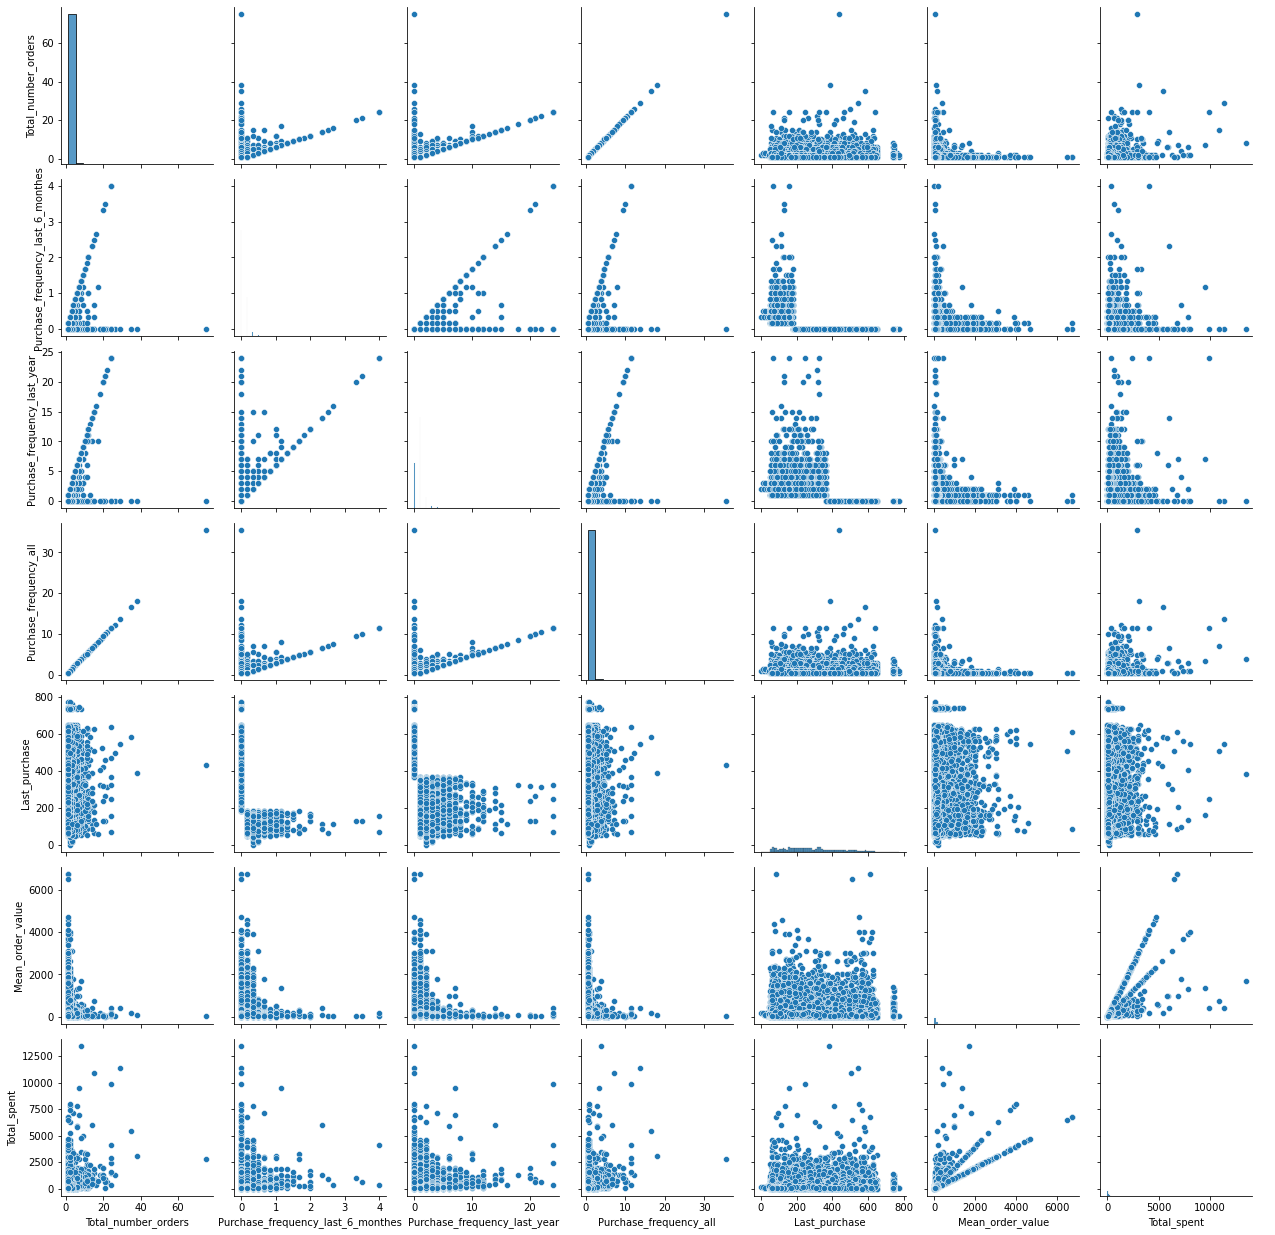

In [8]:
g = sns.PairGrid(data_RFM)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

#### On all period :

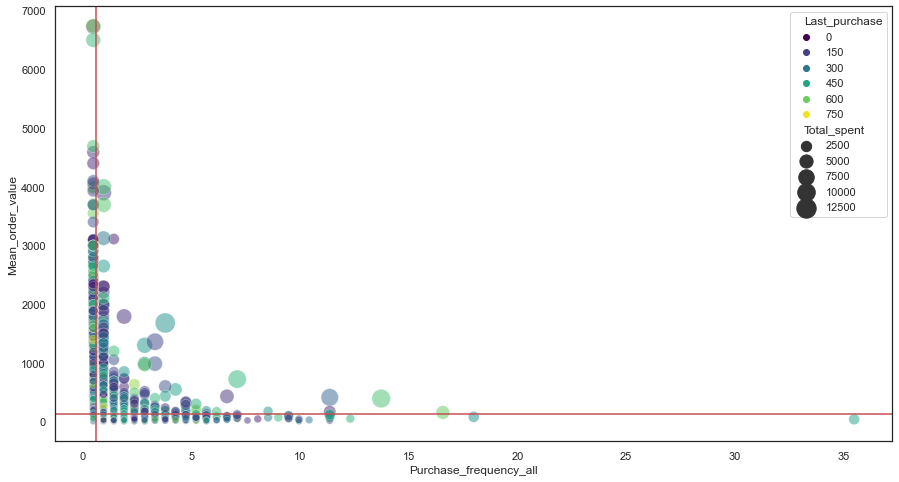

In [9]:
sns.set_theme(style="white")
plt.figure(figsize=(15,8))
sns.scatterplot(data=data_RFM, x="Purchase_frequency_all", y="Mean_order_value", 
                hue="Last_purchase", alpha=0.5, size="Total_spent", sizes=(40, 400), palette='viridis')
x_mean = data_RFM['Purchase_frequency_all'].mean()
y_mean = data_RFM['Mean_order_value'].mean()
plt.axhline(y=y_mean, color='r', linestyle='-')
plt.axvline(x=x_mean, color='r', linestyle='-')

#### Last year :

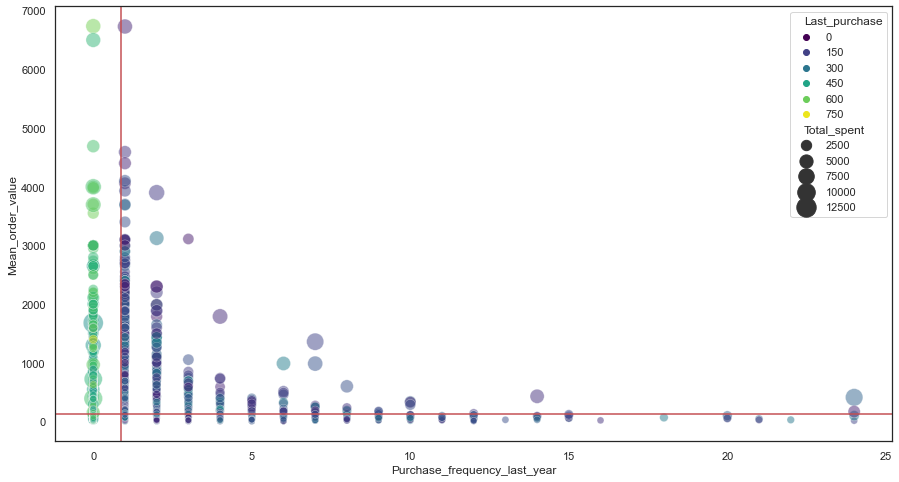

In [10]:
sns.set_theme(style="white")
plt.figure(figsize=(15,8))
sns.scatterplot(data=data_RFM, x="Purchase_frequency_last_year", y="Mean_order_value", 
                hue="Last_purchase", alpha=0.5, size="Total_spent", sizes=(40, 400), palette='viridis')
x_mean = data_RFM['Purchase_frequency_last_year'].mean()
y_mean = data_RFM['Mean_order_value'].mean()
plt.axhline(y=y_mean, color='r', linestyle='-')
plt.axvline(x=x_mean, color='r', linestyle='-')

#### Last 6 monthes :

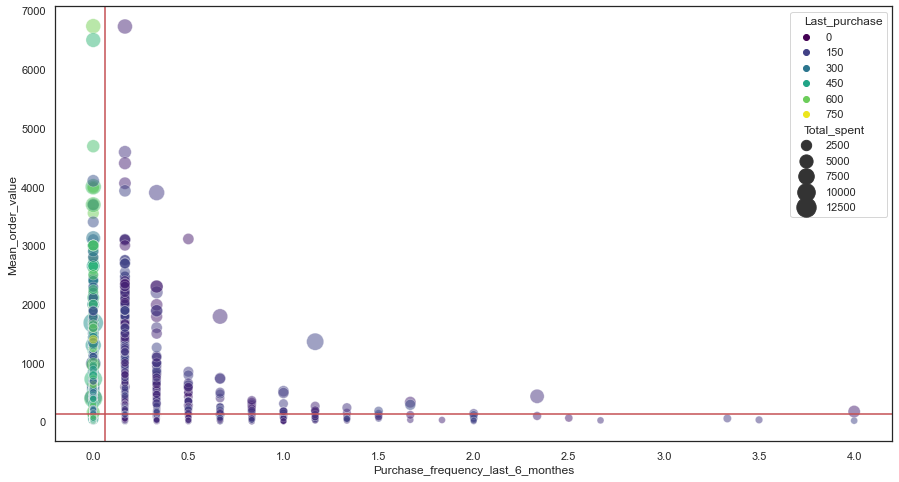

In [11]:
sns.set_theme(style="white")
plt.figure(figsize=(15,8))
sns.scatterplot(data=data_RFM, x="Purchase_frequency_last_6_monthes", y="Mean_order_value", 
                hue="Last_purchase", alpha=0.5, size="Total_spent", sizes=(40, 400), palette='viridis')
x_mean = data_RFM['Purchase_frequency_last_6_monthes'].mean()
y_mean = data_RFM['Mean_order_value'].mean()
plt.axhline(y=y_mean, color='r', linestyle='-')
plt.axvline(x=x_mean, color='r', linestyle='-')

## RFM Clustering :

In [12]:
# Transformer creating the clustering feature :

class RFM_clustering(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        print("Going through RFM_clustering")
        print("Shape of data at this point : ", X.shape)
        return self
    def transform(self, X):
        X_ = X.copy(deep=True)
        
        X_['RFM_cluster'] = 0
        X_['Frequency_cluster'] = 0
        X_['Recency_cluster'] = 0
        X_['Monetary_cluster'] = 0
        
         
        # Intermediary Clustering
        
        X_.loc[X_.Purchase_frequency_all<=X_['Purchase_frequency_all'].quantile(1/3), "Frequency_cluster"] = 1
        # to deal with the fact that both quartile(1/3) and quartile(2/3) are equals :
        X_['intermediate_freq'] = X_['Purchase_frequency_all'][X_['Purchase_frequency_all']>X_['Purchase_frequency_all'].quantile(1/3)]
        X_.loc[(X_.Purchase_frequency_all>X_['Purchase_frequency_all'].quantile(1/3))&(X_.intermediate_freq<=X_['intermediate_freq'].median()), "Frequency_cluster"] = 2
        X_.loc[(X_.intermediate_freq>X_['intermediate_freq'].median()), "Frequency_cluster"] = 3
        X_.drop(columns=['intermediate_freq'], inplace=True)
        
        
        # Caution : inversed scoring for Last purchase : the higher the least recent
        X_.loc[X_.Last_purchase<=X_['Last_purchase'].quantile(1/3), "Recency_cluster"] = 3
        X_.loc[(X_.Last_purchase>X_['Last_purchase'].quantile(1/3))&(X_.Last_purchase<=X_['Last_purchase'].quantile(2/3)), "Recency_cluster"] = 2
        X_.loc[X_.Last_purchase>X_['Last_purchase'].quantile(2/3), "Recency_cluster"] = 1
        
        X_.loc[X_.Total_spent<=X_['Total_spent'].quantile(1/3), "Monetary_cluster"] = 1
        X_.loc[(X_.Total_spent>X_['Total_spent'].quantile(1/3))&(X_.Total_spent<=X_['Total_spent'].quantile(2/3)), "Monetary_cluster"] = 2
        X_.loc[X_.Total_spent>X_['Total_spent'].quantile(2/3), "Monetary_cluster"] = 3
    
        # Final clustering :
        
        counter = 0
        cluster_index = [1, 2, 3]
        
        for feat1 in cluster_index:
            for feat2 in cluster_index:
                for feat3 in cluster_index:
                    X_.loc[(X_.Frequency_cluster==feat1)&(X_.Recency_cluster==feat2)&(X_.Monetary_cluster==feat3), "RFM_cluster"] = counter
                    counter = counter + 1
        
        self.features = list(X_.columns)
        return X_
    
    def get_feature_names_out(self, input_features=None):
        feature_names = self.features
        return np.asarray(feature_names, dtype=object)


tf = RFM_clustering()
tf.fit(data_RFM)
RFM_clustered_data = tf.transform(data_RFM)
print("Shape of data after transformation : ", RFM_clustered_data.shape)
print(RFM_clustered_data.columns)
RFM_clustered_data

Going through RFM_clustering
Shape of data at this point :  (95420, 7)
Shape of data after transformation :  (95420, 11)
Index(['Total_number_orders', 'Purchase_frequency_last_6_monthes',
       'Purchase_frequency_last_year', 'Purchase_frequency_all',
       'Last_purchase', 'Mean_order_value', 'Total_spent', 'RFM_cluster',
       'Frequency_cluster', 'Recency_cluster', 'Monetary_cluster'],
      dtype='object')


,Total_number_orders,Purchase_frequency_last_6_monthes,Purchase_frequency_last_year,Purchase_frequency_all,Last_purchase,Mean_order_value,Total_spent,RFM_cluster,Frequency_cluster,Recency_cluster,Monetary_cluster
customer_unique_id,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,0.166667,1.0,0.473122,160,129.90,129.90,7,1,3,2
0000b849f77a49e4a4ce2b2a4ca5be3f,1,0.166667,1.0,0.473122,163,18.90,18.90,6,1,3,1
0000f46a3911fa3c0805444483337064,1,0.000000,0.0,0.473122,585,69.00,69.00,1,1,1,2
0000f6ccb0745a6a4b88665a16c9f078,1,0.000000,0.0,0.473122,369,25.99,25.99,0,1,1,1
0004aac84e0df4da2b147fca70cf8255,1,0.000000,1.0,0.473122,336,180.00,180.00,5,1,2,3
...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2,0.000000,0.0,0.946244,495,785.00,1570.00,11,2,1,3
fffea47cd6d3cc0a88bd621562a9d061,1,0.000000,1.0,0.473122,310,64.89,64.89,4,1,2,2
ffff371b4d645b6ecea244b27531430a,1,0.000000,0.0,0.473122,617,89.90,89.90,1,1,1,2


In [13]:
RFM_clustered_data["RFM_cluster"].value_counts()

3     10252
6      9909
0      9759
7      9463
1      9262
4      8869
8      7891
2      7810
5      7739
17     1884
14     1826
11     1711
10     1229
16     1124
13     1103
20     1016
23      962
26      958
9       631
15      513
12      512
22      265
25      251
19      242
21       85
24       80
18       74
Name: RFM_cluster, dtype: int64

Text(0.5, 1.0, 'Distribution of customers by clusters')

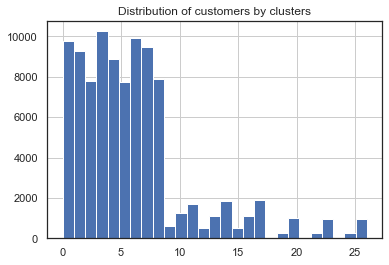

In [14]:
RFM_clustered_data['RFM_cluster'].hist(bins=27)
plt.title('Distribution of customers by clusters')

Text(0.5, 1.0, "Distribution of 'Total_spent'")

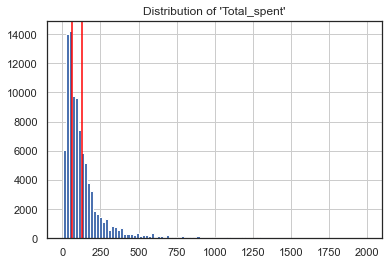

In [15]:
RFM_clustered_data["Total_spent"][RFM_clustered_data["Total_spent"]<2000].hist(bins=100)
plt.axvline(x=RFM_clustered_data["Total_spent"].quantile(1/3), color='red')
plt.axvline(x=RFM_clustered_data["Total_spent"].quantile(2/3), color='red')
plt.title("Distribution of 'Total_spent'")

([], [])

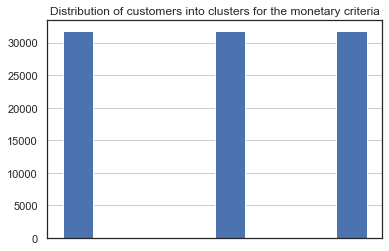

In [16]:
RFM_clustered_data["Monetary_cluster"].hist()
plt.title("Distribution of customers into clusters for the monetary criteria")
plt.xticks([])

Text(0.5, 1.0, "Distribution of 'Purchase_frequency_all'")

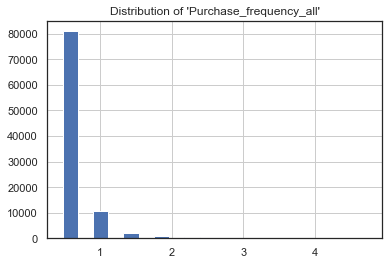

In [17]:
RFM_clustered_data["Purchase_frequency_all"][RFM_clustered_data["Purchase_frequency_all"]<5].hist(bins=20)
plt.title("Distribution of 'Purchase_frequency_all'")

([], [])

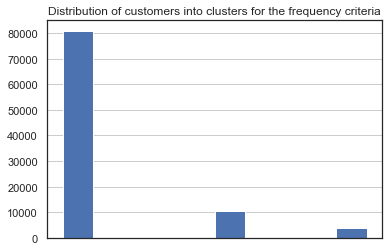

In [18]:
RFM_clustered_data["Frequency_cluster"].hist()
plt.title("Distribution of customers into clusters for the frequency criteria")
plt.xticks([])

Text(0.5, 1.0, "Distribution of 'Last_purchase'")

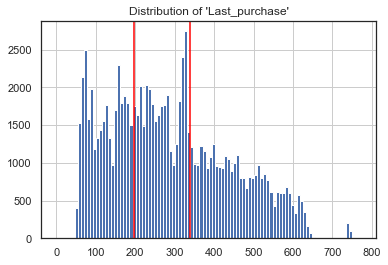

In [19]:
RFM_clustered_data["Last_purchase"].hist(bins=100)
plt.axvline(x=RFM_clustered_data["Last_purchase"].quantile(1/3), color='red')
plt.axvline(x=RFM_clustered_data["Last_purchase"].quantile(2/3), color='red')
plt.title("Distribution of 'Last_purchase'")

([], [])

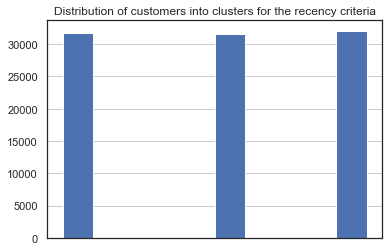

In [20]:
RFM_clustered_data["Recency_cluster"].hist()
plt.title("Distribution of customers into clusters for the recency criteria")
plt.xticks([])

Proposed marketing actions for each cluster :

- Frequency = only one purchase, Recency = far past, Spendings = few amounts : no action
- Frequency = only one purchase, Recency = far past, Spendings = average amounts : no action
- Frequency = only one purchase, Recency = far past, Spendings = big amounts : to get back
- Frequency = only one purchase, Recency = average, Spendings = few amounts : no action
- Frequency = only one purchase, Recency = average, Spendings =  average amounts : no action
- Frequency = only one purchase, Recency = average, Spendings = big amounts : to get back
- Frequency = only one purchase, Recency = recent, Spendings = few amounts : reminder / offer for big spendings 
- Frequency = only one purchase, Recency = recent, Spendings =  average amounts : reminder / offer for big spendings
- Frequency = only one purchase, Recency = recent, Spendings = big amounts : to fidelize quickly

- Frequency = >1 purchase but low frequency, Recency = far past, Spendings = few amounts : no action
- Frequency = >1 purchase but low frequency, Recency = far past, Spendings = average amounts : to get back
- Frequency = >1 purchase but low frequency, Recency = far past, Spendings = big amounts : to get back
- Frequency = >1 purchase but low frequency, Recency = average, Spendings = few amounts : no action
- Frequency = >1 purchase but low frequency, Recency = average, Spendings =  average amounts : to assure fidelization
- Frequency = >1 purchase but low frequency, Recency = average, Spendings = big amounts : to assure fidelization
- Frequency = >1 purchase but low frequency, Recency = recent, Spendings = few amounts : incentive to spend more
- Frequency = >1 purchase but low frequency, Recency = recent, Spendings =  average amounts : to assure fidelization
- Frequency = >1 purchase but low frequency, Recency = recent, Spendings = big amounts : to assure fidelization

- Frequency = high frequency, Recency = far past, Spendings = few amounts : reminder
- Frequency = high frequency, Recency = far past, Spendings = average amounts : to get back /understand why they left
- Frequency = high frequency, Recency = far past, Spendings = big amounts : special offer to get back /understand why they left
- Frequency = high frequency, Recency = average, Spendings = few amounts : incentive to spend more
- Frequency = high frequency, Recency = average, Spendings =  average amounts : to assure fidelization
- Frequency = high frequency, Recency = average, Spendings = big amounts : special offer to get back / fidelization reward
- Frequency = high frequency, Recency = recent, Spendings = few amounts : incentive to spend more
- Frequency = high frequency, Recency = recent, Spendings =  average amounts : fidelization reward
- Frequency = high frequency, Recency = recent, Spendings = big amounts : fidelization reward


**Based on these marketing actions for each cluster, we can group the clusters with the same marketing actions to get a clearer clustering :**
- No action : clusters 0, 1, 3, 4, 9, 12
- To get back : clusters 2, 5, 10, 11, 19
- Reminder / offer for big spendings : clusters : 6, 7, 18
- To fidelize quickly : cluster 8
- To assure fidelization : clusters 13, 14, 16, 17, 22
- Incentive to spend more : clusters 15, 21, 24
- Understand why they left : clusters 19, 20
- Fidelization reward : clusters 23, 25, 26

In [21]:
# Transformer creating the clustering feature :

class Grouped_RFM_clustering(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        print("Going through Grouped_RFM_clustering")
        print("Shape of data at this point : ", X.shape)
        return self
    def transform(self, X):
        X_ = X.copy(deep=True)
        
        X_['Grouped_RFM_cluster'] = 0
        
                
        X_.loc[(X_.RFM_cluster==0)|(X_.RFM_cluster==1)|(X_.RFM_cluster==3)|(X_.RFM_cluster==4)|(X_.RFM_cluster==9)|(X_.RFM_cluster==12), "Grouped_RFM_cluster"] = "No action"
        X_.loc[(X_.RFM_cluster==2)|(X_.RFM_cluster==5)|(X_.RFM_cluster==10)|(X_.RFM_cluster==11)|(X_.RFM_cluster==19), "Grouped_RFM_cluster"] = "To get back"
        X_.loc[(X_.RFM_cluster==6)|(X_.RFM_cluster==7)|(X_.RFM_cluster==18), "Grouped_RFM_cluster"] = "Reminder / offer"
        X_.loc[(X_.RFM_cluster==8), "Grouped_RFM_cluster"] = "To fidelize quickly"
        X_.loc[(X_.RFM_cluster==13)|(X_.RFM_cluster==14)|(X_.RFM_cluster==16)|(X_.RFM_cluster==17)|(X_.RFM_cluster==22), "Grouped_RFM_cluster"] = "To assure fidelization"
        X_.loc[(X_.RFM_cluster==15)|(X_.RFM_cluster==21)|(X_.RFM_cluster==24), "Grouped_RFM_cluster"] = "Incentive to spend more"
        X_.loc[(X_.RFM_cluster==19)|(X_.RFM_cluster==20), "Grouped_RFM_cluster"] = "Understand why they left"
        X_.loc[(X_.RFM_cluster==23)|(X_.RFM_cluster==25)|(X_.RFM_cluster==26), "Grouped_RFM_cluster"] = "Fidelization reward"
                
        
        self.features = list(X_.columns)
        return X_
    
    def get_feature_names_out(self, input_features=None):
        feature_names = self.features
        return np.asarray(feature_names, dtype=object)


tf = Grouped_RFM_clustering()
tf.fit(RFM_clustered_data)
RFM_grouped_data = tf.transform(RFM_clustered_data)
print("Shape of data after transformation : ", RFM_grouped_data.shape)
print(RFM_grouped_data.columns)
RFM_grouped_data

Going through Grouped_RFM_clustering
Shape of data at this point :  (95420, 11)
Shape of data after transformation :  (95420, 12)
Index(['Total_number_orders', 'Purchase_frequency_last_6_monthes',
       'Purchase_frequency_last_year', 'Purchase_frequency_all',
       'Last_purchase', 'Mean_order_value', 'Total_spent', 'RFM_cluster',
       'Frequency_cluster', 'Recency_cluster', 'Monetary_cluster',
       'Grouped_RFM_cluster'],
      dtype='object')


,Total_number_orders,Purchase_frequency_last_6_monthes,Purchase_frequency_last_year,Purchase_frequency_all,Last_purchase,Mean_order_value,Total_spent,RFM_cluster,Frequency_cluster,Recency_cluster,Monetary_cluster,Grouped_RFM_cluster
customer_unique_id,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,0.166667,1.0,0.473122,160,129.90,129.90,7,1,3,2,Reminder / offer
0000b849f77a49e4a4ce2b2a4ca5be3f,1,0.166667,1.0,0.473122,163,18.90,18.90,6,1,3,1,Reminder / offer
0000f46a3911fa3c0805444483337064,1,0.000000,0.0,0.473122,585,69.00,69.00,1,1,1,2,No action
0000f6ccb0745a6a4b88665a16c9f078,1,0.000000,0.0,0.473122,369,25.99,25.99,0,1,1,1,No action
0004aac84e0df4da2b147fca70cf8255,1,0.000000,1.0,0.473122,336,180.00,180.00,5,1,2,3,To get back
...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2,0.000000,0.0,0.946244,495,785.00,1570.00,11,2,1,3,To get back
fffea47cd6d3cc0a88bd621562a9d061,1,0.000000,1.0,0.473122,310,64.89,64.89,4,1,2,2,No action
ffff371b4d645b6ecea244b27531430a,1,0.000000,0.0,0.473122,617,89.90,89.90,1,1,1,2,No action


<AxesSubplot:>

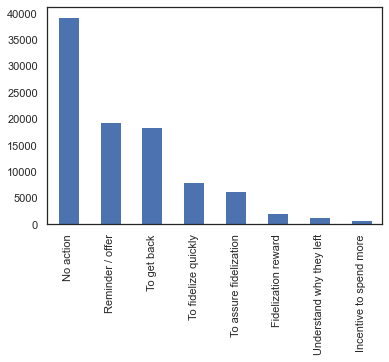

In [22]:
RFM_grouped_data['Grouped_RFM_cluster'].value_counts().plot.bar()

### Other way to group clusters (independent from further marketing actions) :
- Best customers (have the highest values in the 3 features) : cluster 26
- Loyal customers (have the highest values for frequency) : clusters 18 to 26 (the 15% who come back, here)
- Big spenders (have the highest values for the monetary feature) : clusters 2, 5, 8, 11, 14, 17, 20, 23 and 26
- Almost lost customers (still recent but only purchased once) : clusters 6, 7 & 8
- Lost customers (have the lowest recency) : clusters 0, 1, 2, 9, 10, 11, 18, 19, 20

In [23]:
print("Best customers : ", RFM_grouped_data[RFM_grouped_data.RFM_cluster==26].shape[0])
print("Loyal customers : ", RFM_grouped_data[RFM_grouped_data.Frequency_cluster==3].shape[0])
print("Big spenders : ", RFM_grouped_data[RFM_grouped_data.Monetary_cluster==3].shape[0])
print("Almost lost customers : ", RFM_grouped_data[(RFM_grouped_data.Recency_cluster==3)&(RFM_grouped_data.Frequency_cluster==1)].shape[0])
print("Lost customers : ", RFM_grouped_data[RFM_grouped_data.Recency_cluster==1].shape[0])

Best customers :  958
Loyal customers :  3933
Big spenders :  31797
Almost lost customers :  27263
Lost customers :  31734


# Alternative to the RFM segmentation :

The RFM segmentation above has shown some limits like the irrelevancy of Recency for our dataset because 85% of customers do not come back.

Here, we try another clustering based on same features but with Recency getting replaced by encoded feature representing the review score left by the customer (or a value indicating no review was left).

In [24]:
# Transformer creating the clustering feature :

class Alternate_RFM_clustering(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        print("Going through Alternate_RFM_clustering")
        print("Shape of data at this point : ", X.shape)
        return self
    def transform(self, X):
        X_ = X.copy(deep=True)
        
        X_['Alt_RFM_cluster'] = 0
        
        #Total number of orders :
        d = X_.groupby(by=["customer_unique_id"]).count()
        to_merge_number_orders = pd.DataFrame(data={'customer_unique_id': d.index, 'Total_number_orders': d['order_id']})
            
        ## Mean_order_value :
        mv = X_.groupby(by=["customer_unique_id"]).mean()
        mv.rename(columns={'price': "Mean_order_value"}, inplace=True)
        mv = mv[['Mean_order_value']]
        
        ## Total_spent :
        ts = X_.groupby(by=["customer_unique_id"]).sum()
        ts.rename(columns={'price': "Total_spent"}, inplace=True)
        ts = ts[['Total_spent']]
        
        ## Mean_review :
        review = X_.groupby(by=["customer_unique_id"]).mean()
        review.rename(columns={'review_score': "Mean_review_score"}, inplace=True)
        review = review[['Mean_review_score']]
        
        ## Merging all :
        merged = to_merge_number_orders.drop(columns=['customer_unique_id'])
        merged = merged.merge(mv, how='left', left_on='customer_unique_id', right_on='customer_unique_id')
        merged = merged.merge(ts, how='left', left_on='customer_unique_id', right_on='customer_unique_id')
        merged = merged.merge(review, how='left', left_on='customer_unique_id', right_on='customer_unique_id')
        
        X_ = merged.copy()
        
        
        ## Clustering
        
        # Default initialization values :
        X_['alt_M_cluster'] = 0
        X_['alt_F_cluster'] = 0
        X_['alt_Review_cluster'] = "No review"
        
        # Review clustering :
        X_.loc[X_.Mean_review_score.isna(), "alt_Review_cluster"] = "No review" # no change with default value
        X_.loc[X_.Mean_review_score<3, "alt_Review_cluster"] = "Bad review"
        X_.loc[X_.Mean_review_score>=3, "alt_Review_cluster"] = "Good review"
        
        # Scoring / feature-Clustering :
        # Monetary clustering :
        X_.loc[X_.Total_spent<=X_['Total_spent'].quantile(1/3), "alt_M_cluster"] = 1
        X_.loc[(X_.Total_spent>X_['Total_spent'].quantile(1/3))&(X_.Total_spent<=X_['Total_spent'].quantile(2/3)), "alt_M_cluster"] = 2
        X_.loc[X_.Total_spent>X_['Total_spent'].quantile(2/3), "alt_M_cluster"] = 3
        
        # Frequency clustering :
        X_.loc[X_.Total_number_orders<=X_['Total_number_orders'].quantile(1/3), "alt_F_cluster"] = 1
        # intermediate clustering to deal with the fact that both quartile(1/3) and quartile(2/3) are equals :
        X_['intermediate_freq'] = X_['Total_number_orders'][X_['Total_number_orders']>X_['Total_number_orders'].quantile(1/3)]
        X_.loc[(X_.Total_number_orders>X_['Total_number_orders'].quantile(1/3))&(X_.intermediate_freq<=X_['intermediate_freq'].median()), "alt_F_cluster"] = 2
        X_.loc[(X_.intermediate_freq>X_['intermediate_freq'].median()), "alt_F_cluster"] = 3
        X_.drop(columns=['intermediate_freq'], inplace=True)
        
    
                                  
        self.features = list(X_.columns)
        return X_
    
    def get_feature_names_out(self, input_features=None):
        feature_names = self.features
        return np.asarray(feature_names, dtype=object)


tf = Alternate_RFM_clustering()
tf.fit(data)
alt_RFM_data = tf.transform(data)
print("Shape of data after transformation : ", alt_RFM_data.shape)
print(alt_RFM_data.columns)
alt_RFM_data

Going through Alternate_RFM_clustering
Shape of data at this point :  (119143, 47)
Shape of data after transformation :  (96096, 7)
Index(['Total_number_orders', 'Mean_order_value', 'Total_spent',
       'Mean_review_score', 'alt_M_cluster', 'alt_F_cluster',
       'alt_Review_cluster'],
      dtype='object')


,Total_number_orders,Mean_order_value,Total_spent,Mean_review_score,alt_M_cluster,alt_F_cluster,alt_Review_cluster
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,129.90,5.0,2,1,Good review
0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,18.90,4.0,1,1,Good review
0000f46a3911fa3c0805444483337064,1,69.00,69.00,3.0,2,1,Good review
0000f6ccb0745a6a4b88665a16c9f078,1,25.99,25.99,4.0,1,1,Good review
0004aac84e0df4da2b147fca70cf8255,1,180.00,180.00,5.0,3,1,Good review
...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2,785.00,1570.00,5.0,3,2,Good review
fffea47cd6d3cc0a88bd621562a9d061,1,64.89,64.89,4.0,2,1,Good review
ffff371b4d645b6ecea244b27531430a,1,89.90,89.90,5.0,2,1,Good review


In [25]:
alt_RFM_data['alt_Review_cluster'].value_counts()

Good review    81382
Bad review     13998
No review        716
Name: alt_Review_cluster, dtype: int64

#### Interpretable clustering :

- Best customers (high spendings, high nb of orders and give good reviews) 
- Loyal customers (high nb of orders)
- Bad customers (low spendings, only 1 purchase, give bad review)
- Likely satisfied customers (high spendings, high nb of orders but no reviews given)
- Good but unsatisfied customers (high spendings, high nb of orders but bad reviews)
- Fidelization potential customers (only one purchase, good review given)

In [26]:
print("Best customers : ", alt_RFM_data[(alt_RFM_data.alt_M_cluster==3)&(alt_RFM_data.alt_F_cluster==3)&(alt_RFM_data.alt_Review_cluster=="Good review")].shape[0])
print("Loyal customers : ", alt_RFM_data[alt_RFM_data.alt_F_cluster==3].shape[0])
print("Bad customers : ", alt_RFM_data[(alt_RFM_data.alt_M_cluster==1)&(alt_RFM_data.alt_F_cluster==1)&(alt_RFM_data.alt_Review_cluster=="Bad review")].shape[0])
print("Likely satisfied customers : ", alt_RFM_data[(alt_RFM_data.alt_M_cluster==3)&(alt_RFM_data.alt_F_cluster==3)&(alt_RFM_data.alt_Review_cluster=="No review")].shape[0])
print("Good but unsatisfied customers : ", alt_RFM_data[(alt_RFM_data.alt_M_cluster==3)&(alt_RFM_data.alt_F_cluster==3)&(alt_RFM_data.alt_Review_cluster=="Bad review")].shape[0])
print("Fidelization potential customers : ", alt_RFM_data[(alt_RFM_data.alt_M_cluster==3)&(alt_RFM_data.alt_F_cluster==1)&(alt_RFM_data.alt_Review_cluster=="Good review")].shape[0])

Best customers :  2131
Loyal customers :  3941
Bad customers :  4059
Likely satisfied customers :  27
Good but unsatisfied customers :  778
Fidelization potential customers :  19943


# K-Means on RFM features

First step : selecting the features on which to apply the clustering :

In [69]:
data_rfm_kmeans = RFM_grouped_data.copy()
data_rfm_kmeans = data_rfm_kmeans[['Last_purchase', 'Total_number_orders', 'Total_spent']]
data_rfm_kmeans

,Last_purchase,Total_number_orders,Total_spent
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,160,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,18.90
0000f46a3911fa3c0805444483337064,585,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,369,1,25.99
0004aac84e0df4da2b147fca70cf8255,336,1,180.00
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,495,2,1570.00
fffea47cd6d3cc0a88bd621562a9d061,310,1,64.89
ffff371b4d645b6ecea244b27531430a,617,1,89.90


In [70]:
## Preprocessing :

# CustomSimpleImputer to get feature names out :
class CustomSimpleImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='mean'):
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_ = X.copy(deep=True)
        if self.strategy=='mean':
            for col in list(X_.columns):
                mean = X_[col].mean()
                X_[col].fillna(mean)
        if self.strategy=='median':
            for col in list(X_.columns):
                median = X_[col].median()
                X_[col].fillna(median)
                                       
        self.features = list(X_.columns)
        return X_
    
    def get_feature_names_out(self, input_features=None):
        feature_names = self.features
        return np.asarray(feature_names, dtype=object)


num_pipeline = Pipeline([('CustomSimpleImputer', CustomSimpleImputer(strategy='median')),
                         ('scaler', StandardScaler())])

# Transforming data :

data_rfm_kmeans = num_pipeline.fit_transform(data_rfm_kmeans)

data_rfm_kmeans

array([[-0.82985022, -0.28193062, -0.07877633],
       [-0.81026266, -0.28193062, -0.52291052],
       [ 1.94505424, -0.28193062, -0.32244996],
       ...,
       [ 2.15398822, -0.28193062, -0.23882469],
       [-0.77761672, -0.28193062, -0.13839435],
       [ 1.59900733, -0.28193062, -0.37050448]])

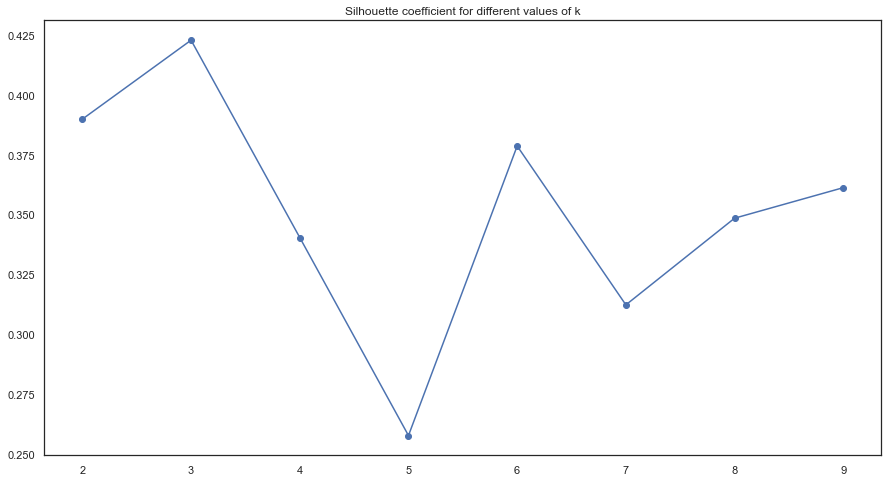

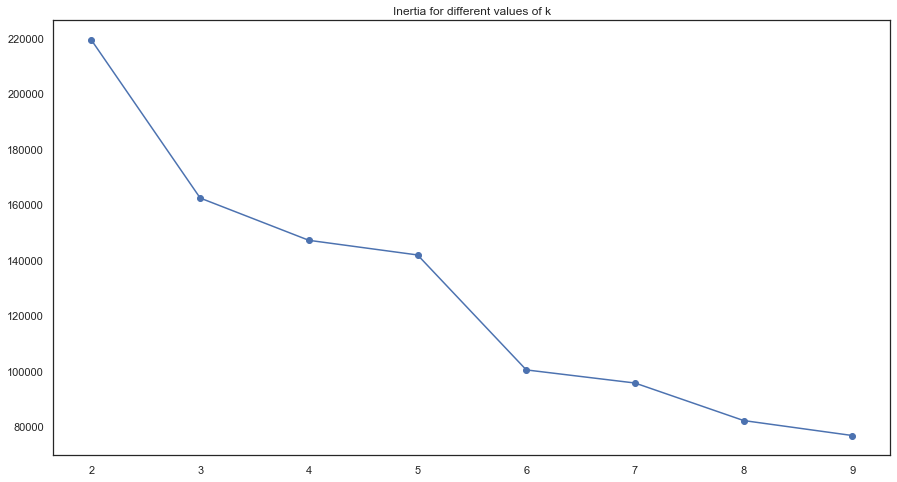

In [71]:
# Select the best k :

silhouettes = []
inertias = []

for num_clusters in range(2,10):
    cls = cluster.KMeans(n_clusters=num_clusters,
                        n_init=1,
                        init='random')
    cls.fit(data_rfm_kmeans)
    silh = metrics.silhouette_score(data_rfm_kmeans, cls.labels_)
    inertias.append(cls.inertia_)
    silhouettes.append(silh)

plt.figure(figsize=(15, 8))
plt.title("Silhouette coefficient for different values of k")
plt.plot(range(2, 10), silhouettes, marker='o')
plt.show()

plt.figure(figsize=(15, 8))
plt.title("Inertia for different values of k")
plt.plot(range(2, 10), inertias, marker='o')
plt.show()


The curves above let us with 3 possibilities : k=3, k=4 or k=5. We are going to create these clusterings and compare them directly on their interpretability :

In [75]:
### Radar plot with Plotly :

import plotly.graph_objs as go
import time

## 1 : re_transforming data into a dataframe :

df_data_rfm_kmeans = pd.DataFrame(data_rfm_kmeans, columns=num_pipeline.get_feature_names_out())

## 2 : Creating grouped values by cluster for each clustering to compare clusters to each other :

t0 = time.time()

# For kmeans with 3 clusters :
kmeans_labels_3 = cluster.KMeans(n_clusters=3, n_init=1, init='random').fit(data_rfm_kmeans).labels_
data_3 = df_data_rfm_kmeans.copy()
data_3["kmeans_label_3"] = kmeans_labels_3
data_grouped_kmeans_3 = data_3.groupby('kmeans_label_3').mean()

t1 = time.time()
print("Delay for building 1st clustering = ", t1-t0)

# For kmeans with 4 clusters :
kmeans_labels_4 = cluster.KMeans(n_clusters=4, n_init=1, init='random').fit(data_rfm_kmeans).labels_
data_4 = df_data_rfm_kmeans.copy()
data_4["kmeans_label_4"] = kmeans_labels_4
data_grouped_kmeans_4 = data_4.groupby('kmeans_label_4').mean()

# For kmeans with 6 clusters :
kmeans_labels_6 = cluster.KMeans(n_clusters=6, n_init=1, init='random').fit(data_rfm_kmeans).labels_
data_6 = df_data_rfm_kmeans.copy()
data_6["kmeans_label_6"] = kmeans_labels_6
data_grouped_kmeans_6 = data_6.groupby('kmeans_label_6').mean()


## 3 : Creating the radar plots :

# For kmeans with 3 clusters :

Radar_Plot_3 = go.Figure()
df = data_grouped_kmeans_3
for group in df.index:
    Radar_Plot_3.add_trace(go.Scatterpolar(r=df[df.index==group].iloc[:,:].values.reshape(-1),
                                         theta=df.columns,
                                         fill='toself',
                                         name='Cluster '+str(group)))
    Radar_Plot_3.update_layout(polar=dict(radialaxis=dict(visible=True,range=[df.min(), df.max()])),
                             showlegend=True,
                             title={'text': "Comparison of clusters for Kmeans with k=3",
                                    'y':0.95,
                                    'x':0.5,
                                    'xanchor': 'center',
                                    'yanchor': 'top'},
                             title_font_color="blue",
                             title_font_size=18)

Radar_Plot_3.show()

# For kmeans with 4 clusters :

Radar_Plot_4 = go.Figure()
df = data_grouped_kmeans_4
for group in df.index:
    Radar_Plot_4.add_trace(go.Scatterpolar(r=df[df.index==group].iloc[:,:].values.reshape(-1),
                                         theta=df.columns,
                                         fill='toself',
                                         name='Cluster '+str(group)))
    Radar_Plot_4.update_layout(polar=dict(radialaxis=dict(visible=True,range=[df.min(), df.max()])),
                             showlegend=True,
                             title={'text': "Comparison of clusters for Kmeans with k=4",
                                    'y':0.95,
                                    'x':0.5,
                                    'xanchor': 'center',
                                    'yanchor': 'top'},
                             title_font_color="blue",
                             title_font_size=18)

Radar_Plot_4.show()

# For kmeans with 5 clusters :

Radar_Plot_6 = go.Figure()
df = data_grouped_kmeans_6
for group in df.index:
    Radar_Plot_6.add_trace(go.Scatterpolar(r=df[df.index==group].iloc[:,:].values.reshape(-1),
                                           theta=df.columns,
                                           fill='toself',
                                           name='Cluster '+str(group)))
    Radar_Plot_6.update_layout(polar=dict(radialaxis=dict(visible=True,range=[df.min(), df.max()])),
                             showlegend=True,
                             title={'text': "Comparison of clusters for Kmeans with k=6",
                                    'y':0.95,
                                    'x':0.5,
                                    'xanchor': 'center',
                                    'yanchor': 'top'},
                             title_font_color="blue",
                             title_font_size=18)

Radar_Plot_6.show()

print('Note : you may have to execute the notebook to see these visualizations as it does not remain after closing it.')

Delay for building 1st clustering =  0.08757829666137695


Note : you may have to execute the notebook to see these visualizations as it does not remain after closing it.


The figures above show the deceptive results : as the clustering with k=6 shows more interesting clusters, some of them seem unuseful for marketing purposes with similarities between some of them (like Cluster 1 and Cluster 5, and Cluster 3 and Cluster 2). 

# K-Means with additional features 

### We are now going to try the k-means algorithm on these RFM features and additional ones to improve usefulness for marketing.

First step : selecting the features on which to apply the clustering :

In [31]:
print(data.shape)
data.columns

(119143, 47)


Index(['Unnamed: 0', 'customer_id', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'order_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm',
       'product_category_name_english', 'seller_zip_code_prefix',
       'seller_city', 'seller_state', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'customer_longitude',
       'cu

In [32]:
data.head()

,Unnamed: 0,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,...,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_longitude,customer_latitude,seller_longitude,seller_latitude,day_of_week_purchase,hour_purchase
0,0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,...,NaN,NaN,2017-05-26 00:00:00,2017-05-30 22:34:40,-47.400367,-20.500253,-46.364539,-23.494316,1,15
1,1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,...,NaN,NaN,2018-01-30 00:00:00,2018-02-10 22:43:29,-46.549350,-23.724844,-48.677675,-26.913214,4,20
2,2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,...,NaN,NaN,2018-06-15 00:00:00,2018-06-15 12:10:59,-46.656404,-23.531294,-46.364539,-23.494316,5,16
3,3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,...,NaN,NaN,2018-03-29 00:00:00,2018-04-02 18:36:47,-46.180817,-23.493944,-46.364539,-23.494316,1,16
4,4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,...,a melhor nota,O baratheon è esxelente Amo adoro o baratheon,2018-08-10 00:00:00,2018-08-17 01:59:52,-47.139272,-22.993053,-48.838906,-21.754867,6,9


We are going to :
- select only orders with order_status == 'delivered'
- group by customer_unique_id
- create potential new features ?
- treat nan values
- select numerical features then scale them
- select categorical features then encode them


In [33]:
for feature in list(data.columns):
    print(feature)
    print(data[feature].unique()[:10])
    print('- '*30)
    print('')

Unnamed: 0
[0 1 2 3 4 5 6 7 8 9]
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

customer_id
['06b8999e2fba1a1fbc88172c00ba8bc7' '18955e83d337fd6b2def6b18a428ac77'
 '4e7b3e00288586ebd08712fdd0374a03' 'b2b6027bc5c5109e529d4dc6358b12c3'
 '4f2d8ab171c80ec8364f7c12e35b23ad' '879864dab9bc3047522c92c82e1212b8'
 'fd826e7cf63160e536e0908c76c3f441' '5e274e7a0c3809e14aba7ad5aae0d407'
 '5adf08e34b2e993982a47070956c5c65' '4b7139f34592b3a31687243a302fa75b']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

customer_unique_id
['861eff4711a542e4b93843c6dd7febb0' '290c77bc529b7ac935b93aa66c333dc3'
 '060e732b5b29e8181a18229c7b0b2b5e' '259dac757896d24d7702b9acbbff3f3c'
 '345ecd01c38d18a9036ed96c73b8d066' '4c93744516667ad3b8f1fb645a3116a4'
 'addec96d2e059c80c30fe6871d30d177' '57b2a98a409812fe9618067b6b8ebe4f'
 '1175e95fb47ddff9de6b2b06188f7e0d' '9afe194fb833f79e300e37e580171f22']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

customer_zip_code_prefix
[14409  9790 

[-47.40036722 -46.54934981 -46.65640409 -46.18081653 -47.13927233
 -49.11768345 -46.67228965 -42.64215075 -49.22418437 -43.97093863]
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

customer_latitude
[-20.5002526  -23.72484431 -23.531294   -23.4939444  -22.99305256
 -26.45323934 -23.58319352 -19.58058    -25.47751785 -19.96659037]
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

seller_longitude
[-46.36453897 -48.67767517 -48.83890601 -46.73173479 -46.63169958
 -46.62914744 -43.2950355  -49.30455056 -47.65577191 -46.82526598]
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

seller_latitude
[-23.49431615 -26.91321409 -21.75486739 -23.49130033 -23.59253391
 -23.61219143 -22.841208   -25.46724037 -22.71492167 -23.00390833]
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

day_of_week_purchase
[1 4 5 6 3 0 2]
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

hour_purchase
[15 20 16  9 18 14 19 12 11 17]
- - - - - - - - - - - - 

**Selection : all customers with 'delivered' order status**

In [34]:
# Transformer creating the dataframe for kmeans :

class kmeans_selecting_features(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        print("Going through kmeans_preparation")
        print("Shape of data at this point : ", X.shape)
        return self
    def transform(self, X):
        X_ = X.copy(deep=True)
        
        ## Selecting orders with 'delivered' order_status only :
        X_ = X_[X_['order_status']=="delivered"]
        
        ##Total number of orders :
        d = X_.groupby(by=["customer_unique_id"]).count()
        to_merge_number_orders = pd.DataFrame(data={'customer_unique_id': d.index, 'Total_number_orders': d['order_id']})
            
        ## Mean_price :
        mv = X_.groupby(by=["customer_unique_id"]).mean()
        mv.rename(columns={'price': "Mean_price"}, inplace=True)
        mv = mv[['Mean_price']]
        
        ## Mean_freight_value :
        Mean_freight_value = X_.groupby(by=["customer_unique_id"]).mean()
        Mean_freight_value.rename(columns={'freight_value': "Mean_freight_value"}, inplace=True)
        Mean_freight_value = Mean_freight_value[['Mean_freight_value']]
        
        ## Total_spent :
        ts = X_.groupby(by=["customer_unique_id"]).sum()
        ts.rename(columns={'price': "Total_spent"}, inplace=True)
        ts = ts[['Total_spent']]
        
        ## encoded_review :
        review = X_.groupby(by=["customer_unique_id"]).mean()
        review = review[['review_score']]
        
        review['encoded_review'] = "No review"
        
        review.loc[review.review_score<=2.5, "encoded_review"] = "Bad review"
        review.loc[(review.review_score>2.5), "encoded_review"] = "Good review"
        review.loc[(review.review_score.isna()), "encoded_review"] = "No review"
        
        review.drop(columns=['review_score'], inplace=True)
        
        
        ## Customer_state :
        state = X_.groupby(by=['customer_unique_id']).agg(pd.Series.mode)
        state = state[['customer_state']]
        
        
                
        ## Merging all :
        merged = to_merge_number_orders.drop(columns=['customer_unique_id'])
        merged = merged.merge(mv, how='left', left_on='customer_unique_id', right_on='customer_unique_id')
        merged = merged.merge(Mean_freight_value, how='left', left_on='customer_unique_id', right_on='customer_unique_id')
        merged = merged.merge(ts, how='left', left_on='customer_unique_id', right_on='customer_unique_id')
        merged = merged.merge(review, how='left', left_on='customer_unique_id', right_on='customer_unique_id')
        merged = merged.merge(state, how='left', left_on='customer_unique_id', right_on='customer_unique_id')
        
        

        X_ = merged.copy()
        
        # Keep "customer_unique_id" into a column :
        X_['customer_unique_id'] = X_.index
        
        
        self.features = list(X_.columns)
        return X_
    
    def get_feature_names_out(self, input_features=None):
        feature_names = self.features
        return np.asarray(feature_names, dtype=object)


tf = kmeans_selecting_features()
tf.fit(data)
data_kmeans = tf.transform(data)
print("Shape of data after transformation : ", data_kmeans.shape)
print(data_kmeans.columns)
data_kmeans

Going through kmeans_preparation
Shape of data at this point :  (119143, 47)
Shape of data after transformation :  (93358, 7)
Index(['Total_number_orders', 'Mean_price', 'Mean_freight_value',
       'Total_spent', 'encoded_review', 'customer_state',
       'customer_unique_id'],
      dtype='object')


,Total_number_orders,Mean_price,Mean_freight_value,Total_spent,encoded_review,customer_state,customer_unique_id
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,12.00,129.90,Good review,SP,0000366f3b9a7992bf8c76cfdf3221e2
0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,8.29,18.90,Good review,SP,0000b849f77a49e4a4ce2b2a4ca5be3f
0000f46a3911fa3c0805444483337064,1,69.00,17.22,69.00,Good review,SC,0000f46a3911fa3c0805444483337064
0000f6ccb0745a6a4b88665a16c9f078,1,25.99,17.63,25.99,Good review,PA,0000f6ccb0745a6a4b88665a16c9f078
0004aac84e0df4da2b147fca70cf8255,1,180.00,16.89,180.00,Good review,SP,0004aac84e0df4da2b147fca70cf8255
...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2,785.00,248.71,1570.00,Good review,PE,fffcf5a5ff07b0908bd4e2dbc735a684
fffea47cd6d3cc0a88bd621562a9d061,1,64.89,19.69,64.89,Good review,BA,fffea47cd6d3cc0a88bd621562a9d061
ffff371b4d645b6ecea244b27531430a,1,89.90,22.56,89.90,Good review,MT,ffff371b4d645b6ecea244b27531430a


In [35]:
tf.get_feature_names_out()

array(['Total_number_orders', 'Mean_price', 'Mean_freight_value',
       'Total_spent', 'encoded_review', 'customer_state',
       'customer_unique_id'], dtype=object)

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

## Numerical pipeline

# CustomSimpleImputer to get feature names out :
class CustomSimpleImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='mean'):
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_ = X.copy(deep=True)
        if self.strategy=='mean':
            for col in list(X_.columns):
                mean = X_[col].mean()
                X_[col].fillna(mean)
        if self.strategy=='median':
            for col in list(X_.columns):
                median = X_[col].median()
                X_[col].fillna(median)
                                       
        self.features = list(X_.columns)
        return X_
    
    def get_feature_names_out(self, input_features=None):
        feature_names = self.features
        return np.asarray(feature_names, dtype=object)


num_pipeline = Pipeline([('CustomSimpleImputer', CustomSimpleImputer(strategy='median')),
                         ('scaler', StandardScaler())])

## Categorical pipeline

# Simple transformer to assure all categorical data can be encoded by the OneHotEncoder :
class To_str(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_ = X.copy(deep=True)
        X_ = X_.astype(str)
                                       
        self.features = list(X_.columns)
        return X_
    
    def get_feature_names_out(self, input_features=None):
        feature_names = self.features
        return np.asarray(feature_names, dtype=object)


cat_pipeline = Pipeline([('to_str', To_str()),
                         ('encoder', OneHotEncoder())])

## Numerical features :

num_features_to_process = ["Total_number_orders", 
                           "Mean_price", 
                           "Mean_freight_value", 
                           "Total_spent"]

## Categorical features :

cat_features_to_process = ["customer_state",
                           "encoded_review"]


## Full pipeline :

full_pipeline = ColumnTransformer([("num", num_pipeline, num_features_to_process),
                                   ("cat", cat_pipeline, cat_features_to_process)],
                                   remainder='passthrough',
                                   sparse_threshold=0)

full_pipeline.fit(data_kmeans)

processed_data_kmeans = full_pipeline.transform(data_kmeans)

processed_data_kmeans

array([[-0.28214688948785654, 0.02133807933895451, -0.5210161093869642,
        ..., 1.0, 0.0, '0000366f3b9a7992bf8c76cfdf3221e2'],
       [-0.28214688948785654, -0.561217036449685, -0.7571944805876851,
        ..., 1.0, 0.0, '0000b849f77a49e4a4ce2b2a4ca5be3f'],
       [-0.28214688948785654, -0.29827999770183955, -0.18871123130940018,
        ..., 1.0, 0.0, '0000f46a3911fa3c0805444483337064'],
       ...,
       [-0.28214688948785654, -0.18859169211641105, 0.1512328393676482,
        ..., 1.0, 0.0, 'ffff371b4d645b6ecea244b27531430a'],
       [-0.28214688948785654, -0.056860760528169185,
        -0.09513112196571816, ..., 1.0, 0.0,
        'ffff5962728ec6157033ef9805bacc48'],
       [-0.28214688948785654, -0.36131141158131314, -0.35741006788134355,
        ..., 1.0, 0.0, 'ffffd2657e2aad2907e67c3e9daecbeb']], dtype=object)

In [37]:
df = pd.DataFrame(processed_data_kmeans, columns=full_pipeline.get_feature_names_out())
useful_for_kmeans = list(df.columns)
useful_for_kmeans.remove("remainder__customer_unique_id")
array_useful = np.array(df[useful_for_kmeans])

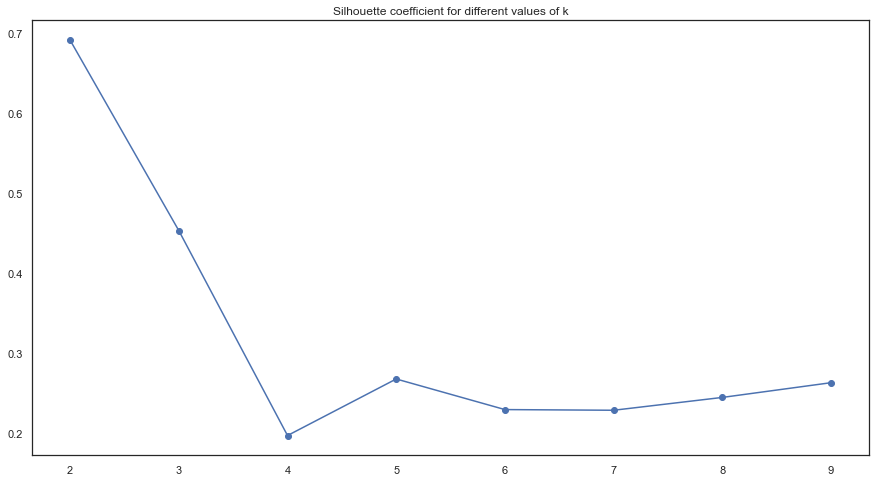

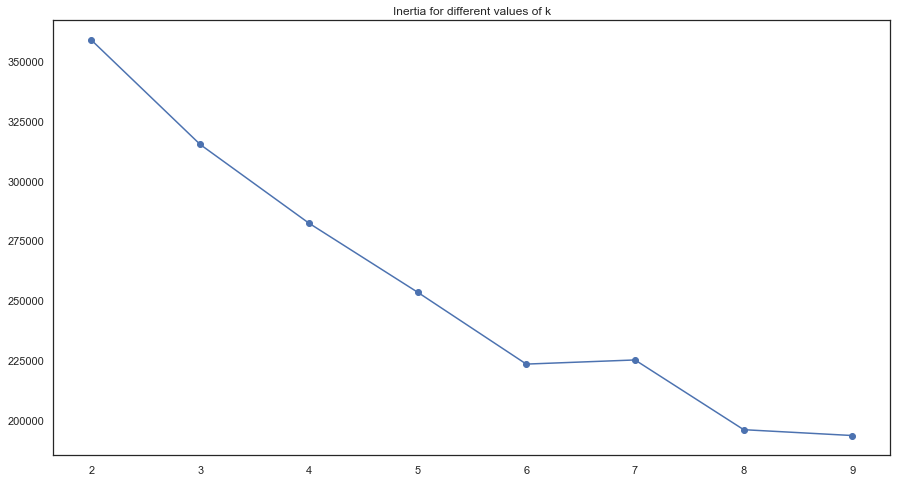

In [38]:
# K-means algorithms to select k, the number of clusters :

from sklearn import cluster, metrics

silhouettes = []
inertias = []

for num_clusters in range(2,10):
    cls = cluster.KMeans(n_clusters=num_clusters,
                        n_init=1,
                        init='random')
    cls.fit(array_useful)
    silh = metrics.silhouette_score(array_useful, cls.labels_)
    inertias.append(cls.inertia_)
    silhouettes.append(silh)

plt.figure(figsize=(15, 8))
plt.title("Silhouette coefficient for different values of k")
plt.plot(range(2, 10), silhouettes, marker='o')
plt.show()

plt.figure(figsize=(15, 8))
plt.title("Inertia for different values of k")
plt.plot(range(2, 10), inertias, marker='o')
plt.show()

## With PCA :

In [39]:
# Pour afficher les points (sur 6 dimensions initialement), on fait une PCA : (centering is included in Scikit-Learn)
from sklearn import decomposition

n_comp = 5

pca = decomposition.PCA(n_components=n_comp)
pca.fit(array_useful)
print(pca.explained_variance_ratio_.cumsum())
X_trans = pca.transform(array_useful)

[0.42875505 0.64232937 0.78514434 0.83625647 0.87981053]


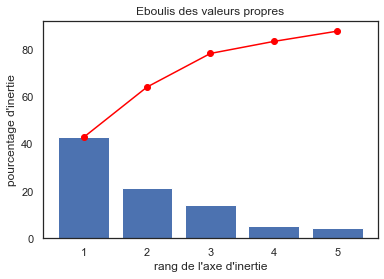

In [40]:
# Screeplot
from functions import *
display_scree_plot(pca) # cf functions.py (custom display function)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


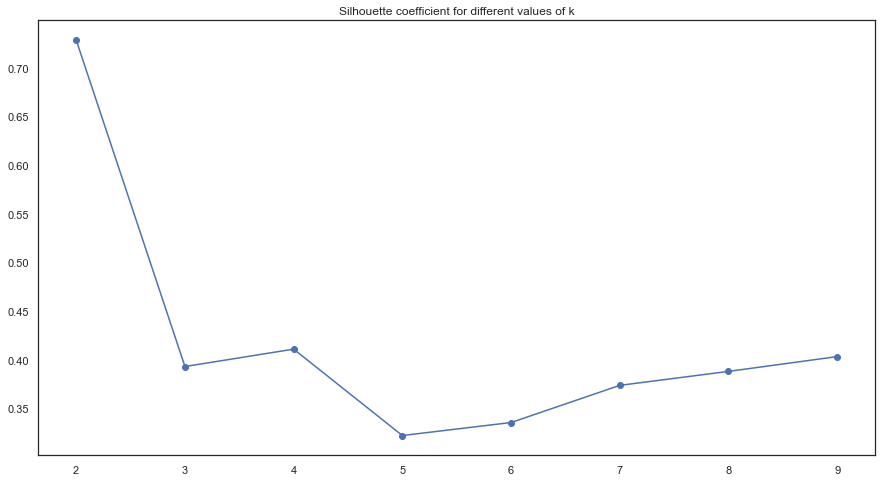

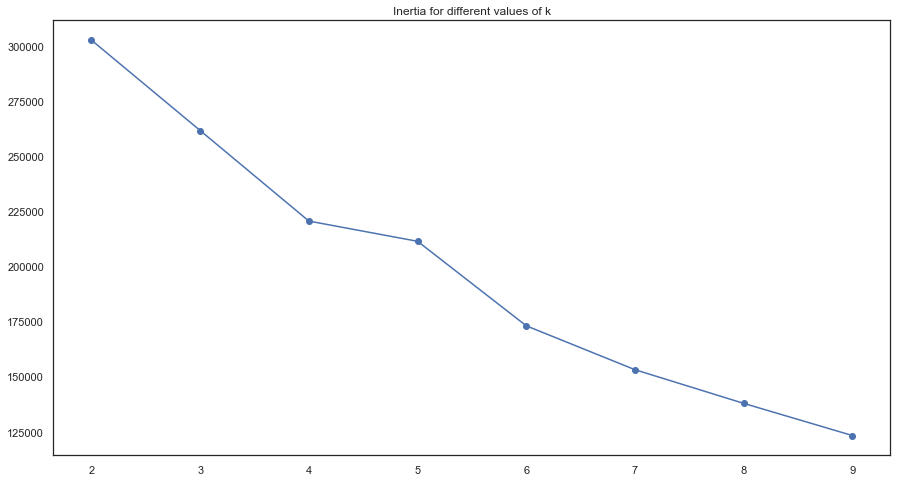

In [41]:
# K-means algorithms to select k, the number of clusters :
%pylab inline
from sklearn import cluster, metrics

silhouettes = []
inertias = []
for num_clusters in range(2,10):
    cls = cluster.KMeans(n_clusters=num_clusters,
                        n_init=1,
                        init='random')
    cls.fit(X_trans)
    silh = metrics.silhouette_score(X_trans, cls.labels_)
    inertias.append(cls.inertia_)
    silhouettes.append(silh)
    

plt.figure(figsize=(15, 8))
plt.title("Silhouette coefficient for different values of k")
plt.plot(range(2, 10), silhouettes, marker='o')
plt.show()

plt.figure(figsize=(15, 8))
plt.title("Inertia for different values of k")
plt.plot(range(2, 10), inertias, marker='o')
plt.show()

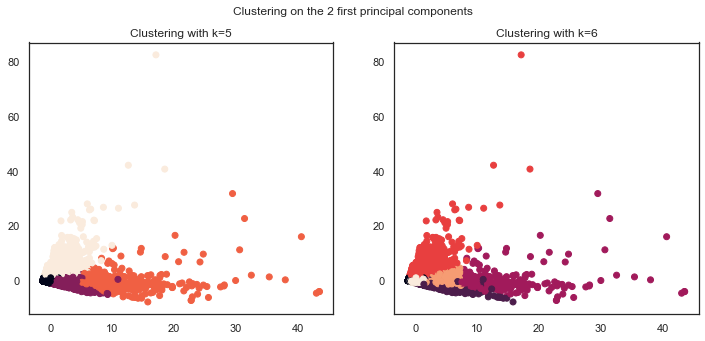

In [42]:
fig = plt.figure(figsize=(12, 5))
plt.suptitle("Clustering on the 2 first principal components")

# Displaying clusters on the 2 principal components features :

cls2 = cluster.KMeans(n_clusters=4)
cls2.fit(array_useful)
ax = fig.add_subplot(121)
ax.scatter(X_trans[:, 0], X_trans[:, 1], c=cls2.labels_)
ax.title.set_text('Clustering with k=5')

cls3 = cluster.KMeans(n_clusters=6)
cls3.fit(array_useful)
ax1 = fig.add_subplot(122)
ax1.scatter(X_trans[:, 0], X_trans[:, 1], c=cls3.labels_)
ax1.title.set_text('Clustering with k=6')

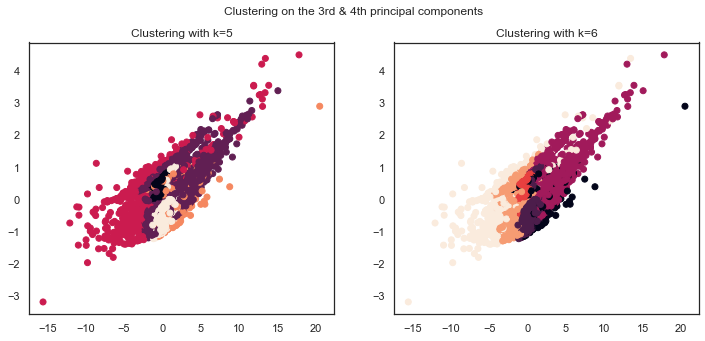

In [43]:
fig = plt.figure(figsize=(12, 5))
plt.suptitle("Clustering on the 3rd & 4th principal components")

# Displaying clusters on the 3rd and 4th principal components features :

cls2 = cluster.KMeans(n_clusters=5)
cls2.fit(array_useful)
ax = fig.add_subplot(121)
ax.scatter(X_trans[:, 2], X_trans[:, 3], c=cls2.labels_)
ax.title.set_text('Clustering with k=5')

cls3 = cluster.KMeans(n_clusters=6)
cls3.fit(array_useful)
ax1 = fig.add_subplot(122)
ax1.scatter(X_trans[:, 2], X_trans[:, 3], c=cls3.labels_)
ax1.title.set_text('Clustering with k=6')

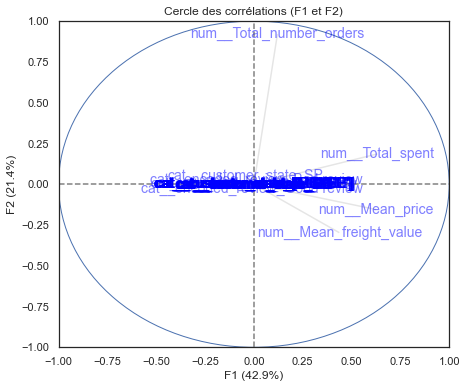

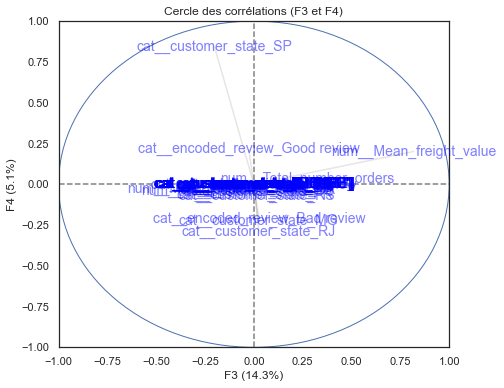

In [44]:
from functions import *

# Cercle des corrélations
pcs = pca.components_
features = full_pipeline.get_feature_names_out()
lims = [-1, 1, -1, 1]
display_circles(pcs, n_comp, pca, [(0,1),(2,3)], labels=features, lims=lims) # cf. functions.py

The interpretation of these synthetic features can be as follows :
- F1 synthetise monetary values of orders
- F2 is directly related with the Total number of orders
- F3 is the less easily understandable but is at least strongly related with the customer state "SP"
- F4 is related with the freight value

**On these 2 graphs, we can clearly see that the encoded features for the customer states seem irrelevant.**

### Analysis of the clusters :

In [45]:
# Data 

data_b = processed_data_kmeans.copy()
data_b = pd.DataFrame(data_b, columns=full_pipeline.get_feature_names_out())
data_b

,num__Total_number_orders,num__Mean_price,num__Mean_freight_value,num__Total_spent,cat__customer_state_AC,cat__customer_state_AL,cat__customer_state_AM,cat__customer_state_AP,cat__customer_state_BA,cat__customer_state_CE,...,cat__customer_state_['PE' 'SP'],cat__customer_state_['PR' 'SC'],cat__customer_state_['RJ' 'SE'],cat__customer_state_['RJ' 'SP'],cat__customer_state_['RS' 'SP'],cat__customer_state_['SC' 'SP'],cat__encoded_review_Bad review,cat__encoded_review_Good review,cat__encoded_review_No review,remainder__customer_unique_id
0,-0.282147,0.021338,-0.521016,-0.076353,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0000366f3b9a7992bf8c76cfdf3221e2
1,-0.282147,-0.561217,-0.757194,-0.528671,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0000b849f77a49e4a4ce2b2a4ca5be3f
2,-0.282147,-0.29828,-0.188711,-0.324517,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0000f46a3911fa3c0805444483337064
3,-0.282147,-0.524007,-0.162611,-0.49978,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0000f6ccb0745a6a4b88665a16c9f078
4,-0.282147,0.284275,-0.209719,0.127801,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0004aac84e0df4da2b147fca70cf8255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93353,0.895616,3.459463,14.547928,5.791964,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,fffcf5a5ff07b0908bd4e2dbc735a684
93354,-0.282147,-0.31985,-0.031471,-0.341265,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,fffea47cd6d3cc0a88bd621562a9d061
93355,-0.282147,-0.188592,0.151233,-0.23935,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,ffff371b4d645b6ecea244b27531430a
93356,-0.282147,-0.056861,-0.095131,-0.137069,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,ffff5962728ec6157033ef9805bacc48


In [46]:
## Kmeans labels

# For kmeans with 2 clusters :
kmeans_labels_2 = cls2.labels_
data_2 = data_b.copy()
data_2["kmeans_label_2"] = kmeans_labels_2
data_grouped_kmeans_2 = data_2.groupby('kmeans_label_2').mean()

# For kmeans with 3 clusters :
kmeans_labels_3 = cls3.labels_
data_3 = data_b.copy()
data_3["kmeans_label_3"] = kmeans_labels_3
data_grouped_kmeans_3 = data_3.groupby('kmeans_label_3').mean()


C:\Users\may81\AppData\Local\Temp\ipykernel_21328\2113224607.py:7: FutureWarning:

Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.

C:\Users\may81\AppData\Local\Temp\ipykernel_21328\2113224607.py:13: FutureWarning:

Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.



In [47]:
data_grouped_kmeans_2

,num__Total_number_orders,num__Mean_price,num__Mean_freight_value,num__Total_spent,cat__customer_state_AC,cat__customer_state_AL,cat__customer_state_AM,cat__customer_state_AP,cat__customer_state_BA,cat__customer_state_CE,...,cat__customer_state_['PB' 'RO'],cat__customer_state_['PE' 'SP'],cat__customer_state_['PR' 'SC'],cat__customer_state_['RJ' 'SE'],cat__customer_state_['RJ' 'SP'],cat__customer_state_['RS' 'SP'],cat__customer_state_['SC' 'SP'],cat__encoded_review_Bad review,cat__encoded_review_Good review,cat__encoded_review_No review
kmeans_label_2,,,,,,,,,,,,,,,,,,,,,
0,-0.146025,-0.198973,-0.434298,-0.212425,0.000000,0.000057,0.000000,0.000029,0.000000,0.000057,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.099969,0.894571,0.005460
1,-0.142158,1.344211,1.905568,1.086264,0.003664,0.014111,0.002714,0.002035,0.049661,0.033243,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.148168,0.844369,0.007463
2,0.148939,7.123556,2.828727,6.691609,0.002281,0.011403,0.003421,0.001140,0.047891,0.019384,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.165336,0.823261,0.011403
3,3.436838,-0.255029,-0.150444,0.696574,0.000806,0.001880,0.001880,0.000537,0.036261,0.010475,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.240398,0.749127,0.010475
4,-0.145887,-0.177655,-0.016647,-0.194730,0.000948,0.005689,0.002370,0.001013,0.056306,0.020557,...,0.000022,0.000043,0.000065,0.000022,0.000043,0.000022,0.000022,0.134549,0.858814,0.006637


In [48]:
data_grouped_kmeans_3

,num__Total_number_orders,num__Mean_price,num__Mean_freight_value,num__Total_spent,cat__customer_state_AC,cat__customer_state_AL,cat__customer_state_AM,cat__customer_state_AP,cat__customer_state_BA,cat__customer_state_CE,...,cat__customer_state_['PB' 'RO'],cat__customer_state_['PE' 'SP'],cat__customer_state_['PR' 'SC'],cat__customer_state_['RJ' 'SE'],cat__customer_state_['RJ' 'SP'],cat__customer_state_['RS' 'SP'],cat__customer_state_['SC' 'SP'],cat__encoded_review_Bad review,cat__encoded_review_Good review,cat__encoded_review_No review
kmeans_label_3,,,,,,,,,,,,,,,,,,,,,
0,3.445044,-0.266979,-0.155945,0.668945,0.000812,0.001895,0.001895,0.000542,0.036556,0.010019,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.240184,0.749255,0.010561
1,-0.144891,-0.156965,-0.003610,-0.177018,0.000932,0.005847,0.002352,0.001038,0.056140,0.021227,...,0.000021,0.000042,0.000064,0.000021,0.000042,0.000021,0.000021,0.134885,0.858399,0.006716
2,-0.153123,0.611878,3.232171,0.468168,0.005985,0.017695,0.003643,0.002342,0.059589,0.036170,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.157169,0.837627,0.005204
3,-0.146333,-0.200316,-0.435381,-0.213900,0.000000,0.000057,0.000000,0.000029,0.000000,0.000172,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.099860,0.894674,0.005467
4,-0.100139,2.784818,0.631253,2.357147,0.001858,0.008981,0.002168,0.001239,0.036854,0.019511,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.136575,0.854134,0.009291
5,0.313263,8.980868,3.322660,8.754756,0.000000,0.011086,0.002217,0.002217,0.050998,0.022173,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.188470,0.798226,0.013304


In [49]:
# Radar plot with Plotly :

import plotly.graph_objs as go

# For kmeans with 2 clusters :

fig = go.Figure()
df = data_grouped_kmeans_2
for cluster in df.index:
    fig.add_trace(go.Scatterpolar(r=df[df.index==cluster].iloc[:,1:].values.reshape(-1),
                                  theta=df.columns[1:],
                                  fill='toself',
                                  name='Cluster '+str(cluster)))
    fig.update_layout(
        polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, 1]
        )),
        showlegend=True,
        title={
            'text': "Comparison of clusters for Kmeans with k=2",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        title_font_color="blue",
        title_font_size=18)

fig.show()

# For kmeans with 3 clusters :

fig = go.Figure()
df = data_grouped_kmeans_3
for cluster in df.index:
    fig.add_trace(go.Scatterpolar(r=df[df.index==cluster].iloc[:,1:].values.reshape(-1),
                                  theta=df.columns[1:],
                                  fill='toself',
                                  name='Cluster '+str(cluster)))
    fig.update_layout(
        polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, 1]
        )),
        showlegend=True,
        title={
            'text': "Comparison of clusters for Kmeans with k=3",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        title_font_color="blue",
        title_font_size=18)

fig.show()  

### As the visualization above aren't clear because of the encoded values for locations of customers (their State), we are going to remove these features :

In [50]:
# Processing :

## Full pipeline :

new_pipeline = ColumnTransformer([("num", num_pipeline, num_features_to_process),
                                  ("OHE", OneHotEncoder(), ["encoded_review"]),
                                  ('pass', "passthrough", ["customer_unique_id"])],
                                 sparse_threshold=0)

new_pipeline.fit(data_kmeans)

new_processed_data = new_pipeline.transform(data_kmeans)

new_processed_data.shape

(93358, 8)

In [51]:
new_processed_data

array([[-0.28214688948785654, 0.02133807933895451, -0.5210161093869642,
        ..., 1.0, 0.0, '0000366f3b9a7992bf8c76cfdf3221e2'],
       [-0.28214688948785654, -0.561217036449685, -0.7571944805876851,
        ..., 1.0, 0.0, '0000b849f77a49e4a4ce2b2a4ca5be3f'],
       [-0.28214688948785654, -0.29827999770183955, -0.18871123130940018,
        ..., 1.0, 0.0, '0000f46a3911fa3c0805444483337064'],
       ...,
       [-0.28214688948785654, -0.18859169211641105, 0.1512328393676482,
        ..., 1.0, 0.0, 'ffff371b4d645b6ecea244b27531430a'],
       [-0.28214688948785654, -0.056860760528169185,
        -0.09513112196571816, ..., 1.0, 0.0,
        'ffff5962728ec6157033ef9805bacc48'],
       [-0.28214688948785654, -0.36131141158131314, -0.35741006788134355,
        ..., 1.0, 0.0, 'ffffd2657e2aad2907e67c3e9daecbeb']], dtype=object)

In [52]:
df = pd.DataFrame(new_processed_data, columns=new_pipeline.get_feature_names_out())
useful_for_kmeans = list(df.columns)
useful_for_kmeans.remove("pass__customer_unique_id")
array_useful = np.array(df[useful_for_kmeans])

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


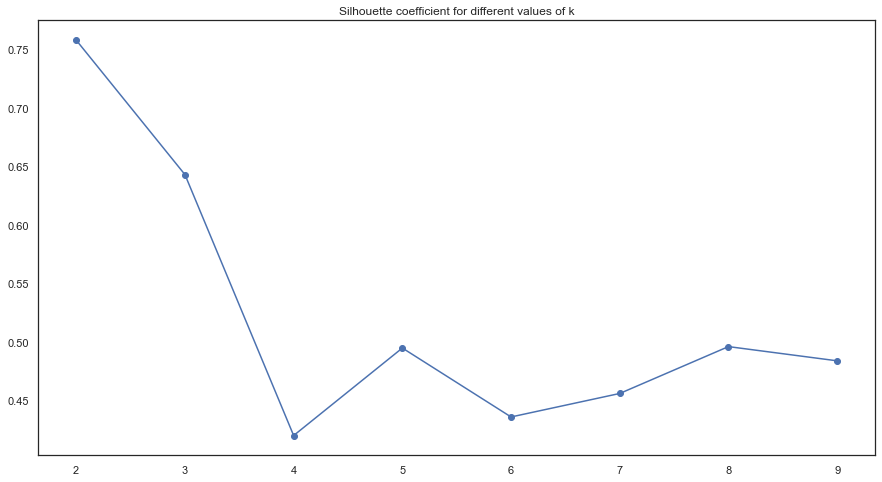

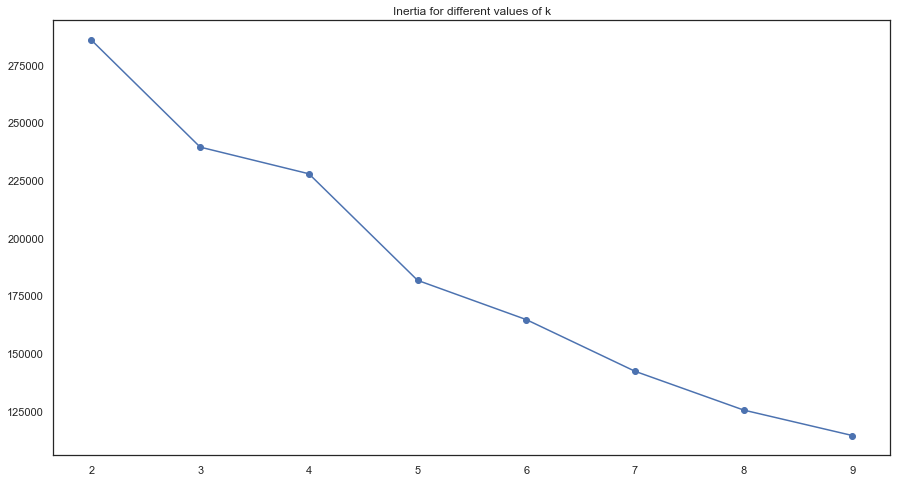

Number of labels in each cluster for the different values of k :
[['2 Clusters', [[0, 89882], [1, 3476]]], ['3 Clusters', [[0, 86505], [1, 3106], [2, 3747]]], ['4 Clusters', [[0, 67919], [1, 11727], [2, 10716], [3, 2996]]], ['5 Clusters', [[0, 71191], [1, 4856], [2, 3645], [3, 549], [4, 13117]]], ['6 Clusters', [[0, 2683], [1, 13687], [2, 1221], [3, 12722], [4, 62683], [5, 362]]], ['7 Clusters', [[0, 3696], [1, 1256], [2, 14050], [3, 358], [4, 9868], [5, 61502], [6, 2628]]], ['8 Clusters', [[0, 10249], [1, 9816], [2, 60343], [3, 369], [4, 8012], [5, 718], [6, 2991], [7, 860]]], ['9 Clusters', [[0, 2106], [1, 54057], [2, 332], [3, 9343], [4, 865], [5, 9480], [6, 6573], [7, 625], [8, 9977]]]]


In [53]:
# K-means algorithms to select k, the number of clusters :
%pylab inline
from sklearn import cluster, metrics

# Counter function to count labels in each cluster for every value of k :
def counter(a):
    L = []
    unique_a = list(set(a))
    for i in range(len(unique_a)):
        c_i = 0
        for x in a:
            if x==unique_a[i]:
                c_i = c_i + 1
        L.append([unique_a[i], c_i])
    return(L)

# k-means :

silhouettes = []
inertias = []
nb_in_clusters = []
for num_clusters in range(2,10):
    cls = cluster.KMeans(n_clusters=num_clusters,
                        n_init=1,
                        init='random')
    cls.fit(array_useful)
    silh = metrics.silhouette_score(array_useful, cls.labels_)
    inertias.append(cls.inertia_)
    silhouettes.append(silh)
    nb_in_clusters.append([str(num_clusters)+" Clusters", counter(cls.labels_)])
    
plt.figure(figsize=(15, 8))
plt.title("Silhouette coefficient for different values of k")
plt.plot(range(2, 10), silhouettes, marker='o')
plt.show()

plt.figure(figsize=(15, 8))
plt.title("Inertia for different values of k")
plt.plot(range(2, 10), inertias, marker='o')
plt.show()

print("Number of labels in each cluster for the different values of k :")
print(nb_in_clusters)

**The results above drive us to pick k=4 :**

In [54]:
# Data 

data = new_processed_data.copy()
data = pd.DataFrame(new_processed_data, columns=new_pipeline.get_feature_names_out())
data

,num__Total_number_orders,num__Mean_price,num__Mean_freight_value,num__Total_spent,OHE__encoded_review_Bad review,OHE__encoded_review_Good review,OHE__encoded_review_No review,pass__customer_unique_id
0,-0.282147,0.021338,-0.521016,-0.076353,0.0,1.0,0.0,0000366f3b9a7992bf8c76cfdf3221e2
1,-0.282147,-0.561217,-0.757194,-0.528671,0.0,1.0,0.0,0000b849f77a49e4a4ce2b2a4ca5be3f
2,-0.282147,-0.29828,-0.188711,-0.324517,0.0,1.0,0.0,0000f46a3911fa3c0805444483337064
3,-0.282147,-0.524007,-0.162611,-0.49978,0.0,1.0,0.0,0000f6ccb0745a6a4b88665a16c9f078
4,-0.282147,0.284275,-0.209719,0.127801,0.0,1.0,0.0,0004aac84e0df4da2b147fca70cf8255
...,...,...,...,...,...,...,...,...
93353,0.895616,3.459463,14.547928,5.791964,0.0,1.0,0.0,fffcf5a5ff07b0908bd4e2dbc735a684
93354,-0.282147,-0.31985,-0.031471,-0.341265,0.0,1.0,0.0,fffea47cd6d3cc0a88bd621562a9d061
93355,-0.282147,-0.188592,0.151233,-0.23935,0.0,1.0,0.0,ffff371b4d645b6ecea244b27531430a
93356,-0.282147,-0.056861,-0.095131,-0.137069,0.0,1.0,0.0,ffff5962728ec6157033ef9805bacc48


In [55]:
## Kmeans labels
from sklearn import cluster
from sklearn.preprocessing import MinMaxScaler

df = pd.DataFrame(new_processed_data, columns=new_pipeline.get_feature_names_out())
useful_for_kmeans = list(df.columns)
useful_for_kmeans.remove("pass__customer_unique_id")
array_useful = np.array(df[useful_for_kmeans])

# For kmeans with 4 clusters :
cls = cluster.KMeans(n_clusters=4)
cls.fit(array_useful)
kmeans_labels = cls.labels_
data_k = data[useful_for_kmeans]
cols = data_k.columns

data_k["kmeans_label"] = kmeans_labels
data_grouped_kmeans = data_k.groupby('kmeans_label').mean()

std = StandardScaler().fit(data_grouped_kmeans)
data_grouped_kmeans = std.transform(data_grouped_kmeans)
data_grouped_kmeans = pd.DataFrame(data_grouped_kmeans, columns=cols)



In [56]:
data_grouped_kmeans

,num__Total_number_orders,num__Mean_price,num__Mean_freight_value,num__Total_spent,OHE__encoded_review_Bad review,OHE__encoded_review_Good review,OHE__encoded_review_No review
0,-0.634988,-0.708292,-0.982232,-0.828440,-1.109867,1.126777,-1.168830
1,1.727533,-0.726546,-0.919812,-0.468650,1.585833,-1.565221,0.751290
2,-0.457981,1.702577,1.387073,1.709873,0.026645,-0.084372,1.204318
3,-0.634565,-0.267738,0.514971,-0.412783,-0.502611,0.522816,-0.786778


In [74]:
# Radar plot with Plotly :

import plotly.graph_objs as go

# For kmeans with 4 clusters :

Radar_Plot = go.Figure()
df = data_grouped_kmeans
for group in df.index:
    Radar_Plot.add_trace(go.Scatterpolar(r=df[df.index==group].iloc[:,:].values.reshape(-1),
                                         theta=df.columns,
                                         fill='toself',
                                         name='Cluster '+str(group)))
    Radar_Plot.update_layout(polar=dict(radialaxis=dict(visible=True,range=[df.min(), df.max()])),
                             showlegend=True,
                             title={'text': "Comparison of clusters for Kmeans with k=4",
                                    'y':0.95,
                                    'x':0.5,
                                    'xanchor': 'center',
                                    'yanchor': 'top'},
                             title_font_color="blue",
                             title_font_size=18)

Radar_Plot.show()

print('Note : you may have to execute the notebook to see this visualization as it does not remain after closing it.')

Note : you may have to execute the notebook to see this visualization as it does not remain after closing it.


**Interpretability for these clusters could be as follows :**

(Nota : assigned numbers to clusters might change with the restart of the Jupyter kernel) 

- Cluster 0 : customers with particularly high freight values
- Cluster 1 : customers who give particularly high score reviews (for everything else at average)
- Cluster 2 : high spending customers not giving reviews or bad reviews for the most
- Cluster 3 : Loyal customers giving bad reviews or not giving reviews

# DBSCAN 

Let's try another algorithm now, DBSCAN :

In [58]:
# Selecting features :

## Full pipeline :

dbs_data = data_kmeans.copy()

dbs_pipeline = ColumnTransformer([("num", num_pipeline, num_features_to_process),
                                  ('pass', "passthrough", ["customer_unique_id"])],
                                 sparse_threshold=0)

dbs_pipeline.fit(dbs_data)

dbs_data = dbs_pipeline.transform(dbs_data)

dbs_data.shape

(93358, 5)

In [59]:
# Getting back a DataFrame :

df = pd.DataFrame(dbs_data, columns=dbs_pipeline.get_feature_names_out())
useful_for_kmeans = list(df.columns)
useful_for_kmeans.remove("pass__customer_unique_id")
array_useful = np.array(df[useful_for_kmeans])

In [60]:
from sklearn.cluster import DBSCAN

dbs = DBSCAN(eps=0.5, min_samples=5).fit(array_useful)

In [61]:
# Number of clusters in labels, ignoring noise if present.

labels = dbs.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 25
Estimated number of noise points: 605


In [62]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(array_useful, labels))

Silhouette Coefficient: 0.333


In [63]:
# Grouping by clusters :

df_data_dbs = data[useful_for_kmeans]
cols = df_data_dbs.columns

df_data_dbs["dbs_label"] = labels
data_grouped_dbs = df_data_dbs.groupby('dbs_label').mean()

std = StandardScaler().fit(data_grouped_dbs)
data_grouped_dbs = std.transform(data_grouped_dbs)
data_grouped_dbs = pd.DataFrame(data_grouped_dbs, columns=cols)

C:\Users\may81\AppData\Local\Temp\ipykernel_21328\574786734.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [73]:
# Radar plot with Plotly :

import plotly.graph_objs as go

Radar_Plot_dbs = go.Figure()
df = data_grouped_dbs
for group in df.index:
    Radar_Plot_dbs.add_trace(go.Scatterpolar(r=df[df.index==group].iloc[:,:].values.reshape(-1),
                                         theta=df.columns,
                                         fill='toself',
                                         name='Cluster '+str(group)))
    Radar_Plot_dbs.update_layout(polar=dict(radialaxis=dict(visible=True,range=[df.min(), df.max()])),
                             showlegend=True,
                             title={'text': "Comparison of clusters for DBSCAN with default parameter values",
                                    'y':0.95,
                                    'x':0.5,
                                    'xanchor': 'center',
                                    'yanchor': 'top'},
                             title_font_color="blue",
                             title_font_size=18)

    
Radar_Plot_dbs.show()

print('Note : you may have to execute the notebook to see this visualization as it does not remain after closing it.')

Note : you may have to execute the notebook to see this visualization as it does not remain after closing it.


This DBSCAN model has too much clusters (25) to give an understandable and operational segmentation.
We are going to try different values of hyperparameters to adjust it, using the silhouette coefficient and the number of cluster to decide which value we will keep :

In [65]:
from tqdm.auto import tqdm

# Hyperparameters possible values :
eps_possible = [0.01, 0.1, 0.5, 0.7]
min_samples_possible = [4, 5, 6]

# Creating models :

models = []

for current_eps in tqdm(eps_possible):
    for current_min_samples in tqdm(min_samples_possible):
        model = DBSCAN(eps=current_eps, min_samples=current_min_samples).fit(array_useful)
        labels = model.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        silhouette = metrics.silhouette_score(array_useful, labels)
        models.append([model, current_eps, current_min_samples, labels, n_clusters, n_noise, silhouette])

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [66]:
## Displaying performances :

silhouettes = []
eps_s = []
min_samples_s = []
n_clusters_s =[]
n_noise_s = []
name_models = []


for model in models :
    silhouettes.append(model[-1])
    n_clusters_s.append(model[4])
    n_noise_s.append(model[5])
    eps_s.append(model[1])
    min_samples_s.append(model[2])
    name_models.append(model[0])
    
comparison_dbs_models = pd.DataFrame({'Name': name_models, 
                                      'eps': eps_s, 
                                      'min_samples': min_samples_s,
                                      'n_clusters': n_clusters_s, 
                                      'n_noise': n_noise_s, 
                                      'silhouette': silhouettes})
comparison_dbs_models

,Name,eps,min_samples,n_clusters,n_noise,silhouette
0,"DBSCAN(eps=0.01, min_samples=4)",0.01,4,2195,19486,-0.333794
1,DBSCAN(eps=0.01),0.01,5,1726,21900,-0.358682
2,"DBSCAN(eps=0.01, min_samples=6)",0.01,6,1434,24004,-0.368813
3,"DBSCAN(eps=0.1, min_samples=4)",0.10,4,197,2837,0.057707
4,DBSCAN(eps=0.1),0.10,5,152,3237,0.061788
5,"DBSCAN(eps=0.1, min_samples=6)",0.10,6,124,3672,0.050894
6,DBSCAN(min_samples=4),0.50,4,43,501,0.326270
7,DBSCAN(),0.50,5,25,605,0.332622
8,DBSCAN(min_samples=6),0.50,6,18,697,0.332962
9,"DBSCAN(eps=0.7, min_samples=4)",0.70,4,33,345,0.336278
